<a href="https://colab.research.google.com/github/Oumayma-O/Mental-health-detection-social-media/blob/main/Mental_health_disorders_detection_on_Reddit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing packages


In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import MaxPooling1D

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.utils import plot_model
import time
import warnings
from collections import Counter


In [ ]:
!pip install --upgrade scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 35.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# Importing data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/adhd_pre_features_tfidf_256.csv'
adhd_pre_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/adhd_post_features_tfidf_256.csv'
adhd_post_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/adhd_2018_features_tfidf_256.csv'
adhd_2018_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/anxiety_pre_features_tfidf_256.csv'
anxiety_pre_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/anxiety_post_features_tfidf_256.csv'
anxiety_post_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/bpd_post_features_tfidf_256.csv'
bpd_post_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/bpd_pre_features_tfidf_256.csv'
bpd_pre_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/bpd_2019_features_tfidf_256.csv'
bpd_2019_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/bpd_2018_features_tfidf_256.csv'
bpd_2018_df = pd.read_csv(dataset_path)

In [ ]:
dataset_path = '/content/drive/MyDrive/pfa/datasets/depression_post_features_tfidf_256.csv'
depression_post_df = pd.read_csv(dataset_path)

In [ ]:
depression_post_df.head()

,subreddit,author,date,post,automated_readability_index,coleman_liau_index,flesch_kincaid_grade_level,flesch_reading_ease,gulpease_index,gunning_fog_index,...,tfidf_wish,tfidf_without,tfidf_wonder,tfidf_work,tfidf_worri,tfidf_wors,tfidf_would,tfidf_wrong,tfidf_x200b,tfidf_year
0,depression,peeepeed,2020/01/01,My heart aches but i cant break Recently my re...,1.173882,3.398981,3.051838,89.945809,82.875000,6.139706,...,0.0,0.0,0.0,0.000000,0.076919,0.000000,0.0,0.0,0.0,0.000000
1,depression,cookieexpertuser,2020/01/01,Cheers I’m not sure if this is the right sub t...,3.418715,4.446295,4.164036,89.847179,72.614458,7.461044,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
2,depression,Ghostiez23,2020/01/01,Fuck titles. I’m depressed I feel so fucking w...,3.225205,5.484992,3.521154,89.113013,75.846154,5.564103,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000
3,depression,wisqrg50,2020/01/01,suffering from low energy I'm not exaggerating...,3.033913,5.780820,4.158870,81.631783,79.434783,6.723478,...,0.0,0.0,0.0,0.213973,0.000000,0.000000,0.0,0.0,0.0,0.000000
4,depression,arizonwatermelon,2020/01/01,I can already tell This year is just going to ...,1.868557,3.664849,2.150075,99.536654,78.253731,5.660697,...,0.0,0.0,0.0,0.000000,0.000000,0.237633,0.0,0.0,0.0,0.300324


# Combining datasets

In [ ]:
# List of DataFrames to combine
dataframes = [adhd_pre_df, adhd_post_df,adhd_2018_df, anxiety_pre_df, anxiety_post_df, bpd_pre_df, bpd_post_df,bpd_2019_df,bpd_2018_df, depression_post_df]

# Initialize an empty DataFrame for the combined data
combined_df = pd.DataFrame()

# Iterate over the list of DataFrames
for df in dataframes:
    # Select only the 'subreddit' and 'post' columns
    temp_df = df[['subreddit', 'post']]
    # Append to the combined DataFrame
    combined_df = pd.concat([combined_df, temp_df], ignore_index=True)


In [ ]:
combined_df.groupby('subreddit').describe()

In [ ]:
# Check the class distribution in the combined DataFrame
class_distribution = combined_df['subreddit'].value_counts()
print(class_distribution)


subreddit
depression    38033
anxiety       35872
adhd          35408
bpd           24294
Name: count, dtype: int64


In [ ]:
combined_df.shape

(133607, 2)

In [ ]:
combined_df.head()

,subreddit,post
0,adhd,How much further ahead could I have been by no...
1,adhd,ADHD &amp; Bipolar Anyone else have Bipolar Di...
2,adhd,My relationship is falling apart and I don’t k...
3,adhd,To those struggling to write papers- drink cof...
4,adhd,Meds didn't cure chronic laziness But I can fo...


In [ ]:
# Add new columns
combined_df['depression'] = 0
combined_df['anxiety'] = 0
combined_df['bpd'] = 0
combined_df['adhd'] = 0

In [ ]:
combined_df.head()

,subreddit,post,depression,anxiety,bpd,adhd
0,adhd,How much further ahead could I have been by no...,0,0,0,0
1,adhd,ADHD &amp; Bipolar Anyone else have Bipolar Di...,0,0,0,0
2,adhd,My relationship is falling apart and I don’t k...,0,0,0,0
3,adhd,To those struggling to write papers- drink cof...,0,0,0,0
4,adhd,Meds didn't cure chronic laziness But I can fo...,0,0,0,0


In [ ]:
# Set column values based on subreddit
combined_df.loc[combined_df['subreddit'] == 'depression', 'depression'] = 1
combined_df.loc[combined_df['subreddit'] == 'anxiety', 'anxiety'] = 1
combined_df.loc[combined_df['subreddit'] == 'bpd', 'bpd'] = 1
combined_df.loc[combined_df['subreddit'] == 'adhd', 'adhd'] = 1


In [ ]:
combined_df.head()

,subreddit,post,depression,anxiety,bpd,adhd
0,adhd,How much further ahead could I have been by no...,0,0,0,1
1,adhd,ADHD &amp; Bipolar Anyone else have Bipolar Di...,0,0,0,1
2,adhd,My relationship is falling apart and I don’t k...,0,0,0,1
3,adhd,To those struggling to write papers- drink cof...,0,0,0,1
4,adhd,Meds didn't cure chronic laziness But I can fo...,0,0,0,1


In [ ]:
combined_df.shape

(133607, 6)

In [ ]:
# Save the combined DataFrame to a file if needed
combined_df.to_csv('/content/drive/MyDrive/pfa/combined_df.csv', index=False)

# Data visualization

In [ ]:
# Load the combined DataFrame from the CSV file
combined_df = pd.read_csv('/content/drive/MyDrive/pfa/combined_df.csv')

In [ ]:
print(combined_df.info())  # Get a summary of the dataset


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133607 entries, 0 to 133606
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   subreddit   133607 non-null  object
 1   post        133607 non-null  object
 2   depression  133607 non-null  int64 
 3   anxiety     133607 non-null  int64 
 4   bpd         133607 non-null  int64 
 5   adhd        133607 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 6.1+ MB
None


In [ ]:
# Check the class distribution
class_distribution = combined_df['subreddit'].value_counts()
print(class_distribution)

subreddit
depression    38033
anxiety       35872
adhd          35408
bpd           24294
Name: count, dtype: int64


<ipython-input-9-8c7da071a42f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


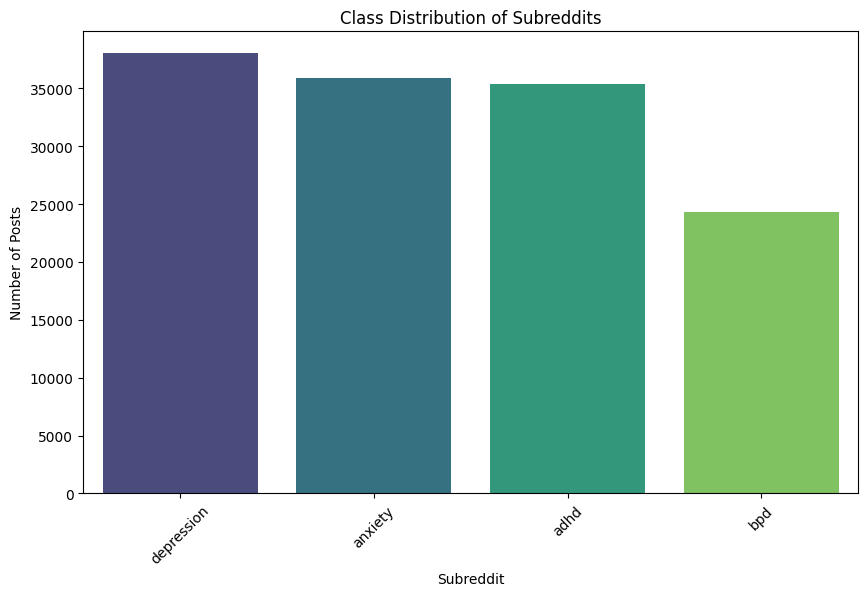

In [ ]:
# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Subreddits')
plt.xlabel('Subreddit')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculate text lengths
combined_df['text_length'] = combined_df['post'].apply(len)

# Plot text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(combined_df['post'], bins=50, kde=True)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [ ]:
print(combined_df.describe())  # Get descriptive statistics of the dataset

          depression        anxiety            bpd           adhd
count  133607.000000  133607.000000  133607.000000  133607.000000
mean        0.284663       0.268489       0.181832       0.265016
std         0.451256       0.443175       0.385707       0.441343
min         0.000000       0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000       0.000000
75%         1.000000       1.000000       0.000000       1.000000
max         1.000000       1.000000       1.000000       1.000000


In [ ]:
print("Missing values in each column:")
print(combined_df.isna().sum())

Missing values in each column:
subreddit     0
post          0
depression    0
anxiety       0
bpd           0
adhd          0
dtype: int64


# Basic Data Cleaning


In [ ]:
# Load the combined DataFrame from the CSV file
df = pd.read_csv('/content/drive/MyDrive/pfa/combined_df.csv')

In [ ]:
# Rename columns to match your dataset
df = df.rename(columns={'post': 'text', 'subreddit': 'label'})

print(df.shape)



(133607, 6)


In [ ]:
# Check for duplicates in the DataFrame
duplicates_exist = df.duplicated(subset='text').any()

# Print the result
if duplicates_exist:
    print("Duplicate rows exist in the DataFrame.")
else:
    print("No duplicate rows found in the DataFrame.")


Duplicate rows exist in the DataFrame.


In [ ]:
# Find duplicated rows based on the 'text' column
duplicated_rows = df[df.duplicated(subset='text', keep=False)]

# Display the duplicated rows
print("Duplicated rows in the DataFrame:")
print(duplicated_rows)


Duplicated rows in the DataFrame:
             label                                               text  \
10262         adhd  Want to create a YouTube place for members her...   
12730         adhd  Your Relationship With Your Therapist (Academi...   
24311         adhd  Wow wow woo cant believe am I dreaming please ...   
25507         adhd  Uni life is hard on me Only the second week to...   
25509         adhd  Uni life is hard on me Only the second week to...   
...            ...                                                ...   
132000  depression  Need for advice I have a boss who to takes eve...   
132335  depression  Why do I act out on social media? I (24M) have...   
132715  depression  Escitalopram and Alprazolam, my first week It'...   
132892  depression  Since we don't have insane asylums anymore, wh...   
133020  depression                 I can’t stop crying Please help me   

        depression  anxiety  bpd  adhd  
10262            0        0    0     1  
12730  

In [ ]:
# Remove duplicate rows based on the 'text' column
df.drop_duplicates(subset='text', keep=False, inplace=True)

print(df.shape)


(128565, 6)


In [ ]:
# Find duplicated rows based on the 'text' column
duplicated_rows = df[df.duplicated(subset='text', keep=False)]

# Display the duplicated rows
print("Duplicated rows in the DataFrame:")
print(duplicated_rows)

Duplicated rows in the DataFrame:
Empty DataFrame
Columns: [label, text, depression, anxiety, bpd, adhd]
Index: []


In [ ]:
# Drop rows with any missing values
df.dropna(inplace=True)
print(df.shape)


(128565, 6)


In [ ]:
# Check the class distribution
class_distribution = df['label'].value_counts()
print(class_distribution)

label
depression    37961
anxiety       35810
adhd          35399
bpd           19395
Name: count, dtype: int64


In [ ]:
# Check for missing values
print(df.isnull().any())
print(df.isna().any())

# Display the shape of the DataFrame
print(df.shape)


label         False
text          False
depression    False
anxiety       False
bpd           False
adhd          False
dtype: bool
label         False
text          False
depression    False
anxiety       False
bpd           False
adhd          False
dtype: bool
(128565, 6)


In [ ]:
# Install the contractions package
!pip install contractions


In [ ]:
import re
import contractions
from html import unescape

# Function to clean and preprocess text
def clean_text(text):
    # Decode HTML entities
    text = unescape(text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove URLs
    text = re.sub(r'http\S+|www.\S+', '', text, flags=re.IGNORECASE)
    # Remove Markdown links
    text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
    # Expand contractions
    text = contractions.fix(text)
    # Encode text as ASCII to remove emojis
    text = text.encode('ascii', 'ignore').decode('ascii')
    # Replace newlines with spaces
    text = re.sub(r'\n', ' ', text)
    # Remove punctuations, numbers, and single characters
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)  # Single character removal
    # Strip leading and trailing spaces
    text = text.strip()
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Convert text to lowercase
    text = text.lower()
    return text

# Example usage
sample_text = "This is an example text with a link [example](http://example.com) and HTML &amp; <b>tags</b>."
cleaned_text = clean_text(sample_text)
print(cleaned_text)

this is an example text with link example and html tags


In [ ]:
# Apply the cleaning function to the 'text' column
df['text'] = df['text'].map(clean_text)

In [ ]:
# Display the first few rows of the cleaned DataFrame
df.head()

,label,text,depression,anxiety,bpd,adhd
0,adhd,how much further ahead could have been by now ...,0,0,0,1
1,adhd,adhd bipolar anyone else have bipolar disorder...,0,0,0,1
2,adhd,my relationship is falling apart and do not kn...,0,0,0,1
3,adhd,to those struggling to write papers drink coff...,0,0,0,1
4,adhd,meds did not cure chronic laziness but can foc...,0,0,0,1


In [ ]:
from nltk.corpus import stopwords

# Download NLTK stopwords data
nltk.download('stopwords')

stop_words = set(nltk.corpus.stopwords.words('english'))

important_stopwords = {'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
                       'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
                       'no', 'not', 'nor', 'never'}

# Function to remove stopwords while keeping important ones
def remove_stopwords(text):
    words = text.split()
    # Remove words that are in stop_words but not in important_stopwords
    words = [word for word in words if word not in stop_words or word in important_stopwords]
    return ' '.join(words)

# Example usage
text = "This is an example sentence where I want to keep certain stopwords like I, me, and not."
cleaned_text = remove_stopwords(text)
print(cleaned_text)


This example sentence I want keep certain stopwords like I, me, not.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
df['text'] = df['text'].map(remove_stopwords)


In [ ]:
df.head()

,label,text,depression,anxiety,bpd,adhd
0,adhd,much ahead could vent sorry it long one diagno...,0,0,0,1
1,adhd,adhd bipolar anyone else bipolar disorder adhd...,0,0,0,1
2,adhd,my relationship falling apart not know my bf f...,0,0,0,1
3,adhd,struggling write papers drink coffee start wee...,0,0,0,1
4,adhd,meds not cure chronic laziness focus intently ...,0,0,0,1


In [ ]:
# Display the shape of the DataFrame after cleaning
df.shape

(128565, 6)

In [ ]:
# Save the cleaned DataFrame to a JSON file
df.to_json('/content/drive/MyDrive/pfa/cleaned_data.json', orient='table')

# More Data Cleaning and preprocessing

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
import pandas as pd

# Download necessary NLTK data
nltk.download('punkt')

# Load the cleaned DataFrame from the JSON file
df = pd.read_json('/content/drive/MyDrive/pfa/cleaned_data.json', orient='table')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

# Function to tokenize text
def tokenize_text(text):
    return word_tokenize(text)

# Apply the tokenization function to the 'text' column
df['tokens'] = df['text'].apply(tokenize_text)


In [ ]:
df.head()

,label,text,depression,anxiety,bpd,adhd,tokens
0,adhd,much ahead could vent sorry it long one diagno...,0,0,0,1,"[much, ahead, could, vent, sorry, it, long, on..."
1,adhd,adhd bipolar anyone else bipolar disorder adhd...,0,0,0,1,"[adhd, bipolar, anyone, else, bipolar, disorde..."
2,adhd,my relationship falling apart not know my bf f...,0,0,0,1,"[my, relationship, falling, apart, not, know, ..."
3,adhd,struggling write papers drink coffee start wee...,0,0,0,1,"[struggling, write, papers, drink, coffee, sta..."
4,adhd,meds not cure chronic laziness focus intently ...,0,0,0,1,"[meds, not, cure, chronic, laziness, focus, in..."


In [ ]:
# Save the cleaned DataFrame to a JSON file
df.to_json('/content/drive/MyDrive/pfa/final_tokenized_cleaned_data.json', orient='table')

In [ ]:
# Load your dataset
df = pd.read_json('/content/drive/MyDrive/pfa/final_tokenized_cleaned_data.json', orient='table')

# Filter the DataFrame by class
depression_texts = df[df['depression'] == 1]['tokens']
anxiety_texts = df[df['anxiety'] == 1]['tokens']
adhd_texts = df[df['adhd'] == 1]['tokens']
bpd_texts = df[df['bpd'] == 1]['tokens']

# Calculate the total number of tokens for each class
def count_tokens(token_series):
    return token_series.apply(lambda x: len(str(x).split())).sum()

total_depression_tokens = count_tokens(depression_texts)
total_anxiety_tokens = count_tokens(anxiety_texts)
total_adhd_tokens = count_tokens(adhd_texts)
total_bpd_tokens = count_tokens(bpd_texts)

# Calculate the total tokens across all classes
total_tokens = total_depression_tokens + total_anxiety_tokens + total_adhd_tokens + total_bpd_tokens

# Calculate the percentage of tokens for each class
percentage_depression_tokens = (total_depression_tokens / total_tokens) * 100
percentage_anxiety_tokens = (total_anxiety_tokens / total_tokens) * 100
percentage_adhd_tokens = (total_adhd_tokens / total_tokens) * 100
percentage_bpd_tokens = (total_bpd_tokens / total_tokens) * 100

# Print total tokens and their percentages for each class
print(f"Total tokens in depression class: {total_depression_tokens} ({percentage_depression_tokens:.2f}%)")
print(f"Total tokens in anxiety class: {total_anxiety_tokens} ({percentage_anxiety_tokens:.2f}%)")
print(f"Total tokens in ADHD class: {total_adhd_tokens} ({percentage_adhd_tokens:.2f}%)")
print(f"Total tokens in BPD class: {total_bpd_tokens} ({percentage_bpd_tokens:.2f}%)")


Total tokens in depression class: 3846065 (30.31%)
Total tokens in anxiety class: 3362469 (26.50%)
Total tokens in ADHD class: 3403931 (26.82%)
Total tokens in BPD class: 2078282 (16.38%)


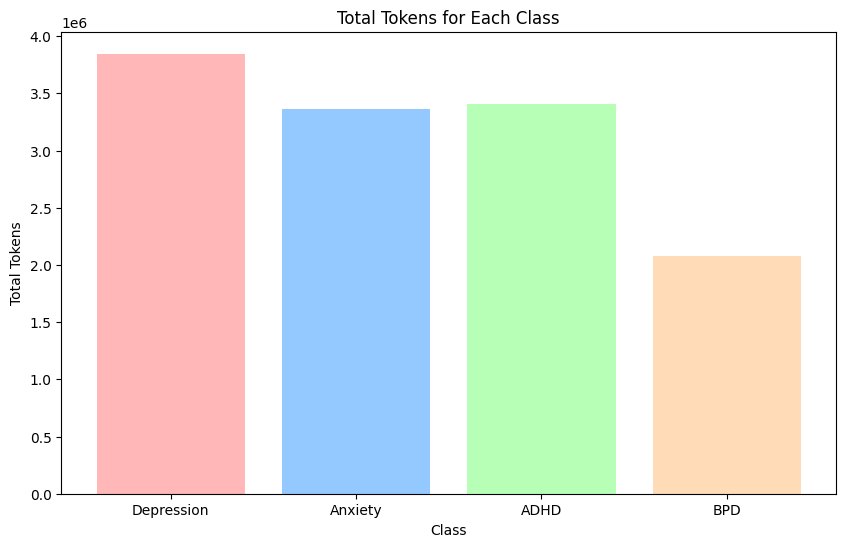

In [ ]:
# Prepare data for plotting
labels = ['Depression', 'Anxiety', 'ADHD', 'BPD']
total_tokens_list = [total_depression_tokens, total_anxiety_tokens, total_adhd_tokens, total_bpd_tokens]
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99']  # Add any colors you prefer

# Plotting the results
plt.figure(figsize=(10, 6))
plt.bar(labels, total_tokens_list, color=colors, alpha=0.7)
plt.xlabel('Class')
plt.ylabel('Total Tokens')
plt.title('Total Tokens for Each Class')
plt.show()

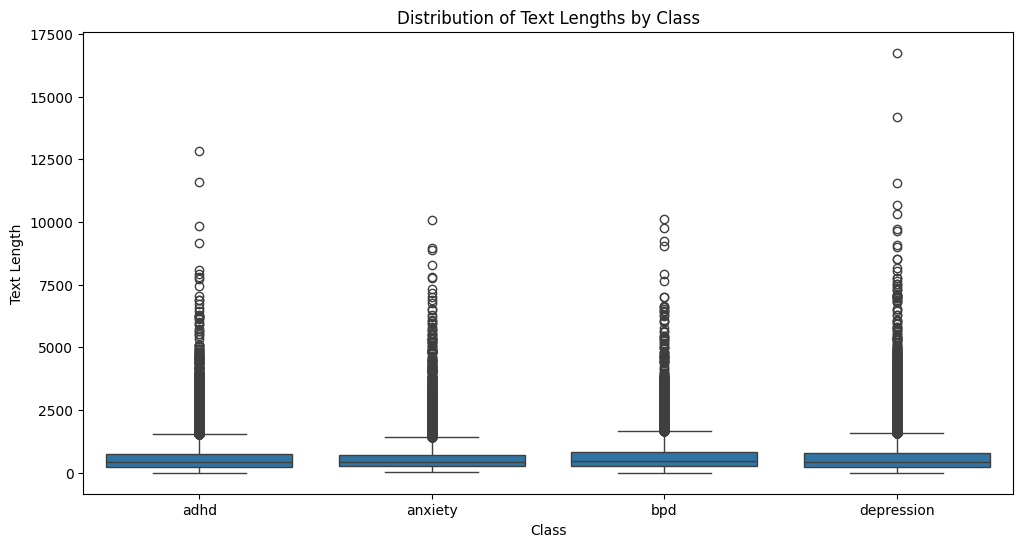

In [ ]:
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='label', y='text_length')
plt.xlabel('Class')
plt.ylabel('Text Length')
plt.title('Distribution of Text Lengths by Class')
plt.show()


This plot shows how long texts are in four different categories: ADHD, anxiety, BPD (borderline personality disorder), and depression. Here's what it tells us:

1. **Categories (bottom labels)**: The four groups are ADHD, anxiety, BPD, and depression.

2. **Text Length (side numbers)**: This shows how long the texts are, either by the number of words or characters.

3. **Boxes**: Each box represents the typical range of text lengths in each category:
   - **Middle Line in Box**: This line shows the middle text length (half are shorter, half are longer).
   - **Box Itself**: The box shows where most text lengths fall.

4. **Lines (Whiskers) and Circles**:
   - **Lines (whiskers)**: These show the range of text lengths that are still considered normal but a bit longer or shorter than most.
   - **Circles (outliers)**: These are texts that are much longer than usual.

What We See:
1. **Typical Lengths**: Most texts in all four categories are about the same length.
2. **Similar Patterns**: The text lengths look pretty similar across all four categories.
3. **Very Long Texts**: Some texts are much longer than usual in all categories, which are shown by the circles.

So, this plot shows that, generally, the length of texts is similar across these four categories, with a few very long texts in each group.

## Lemmatization

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Load the cleaned DataFrame from the JSON file
tokenized_df = pd.read_json('/content/drive/MyDrive/pfa/final_tokenized_cleaned_data.json', orient='table')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
tokenized_df.shape


(128565, 7)

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [ ]:


# Download necessary NLTK data
nltk.download('averaged_perceptron_tagger')

def get_wordnet_pos(tag):
    """Map POS tag to first character lemmatize() accepts"""
    tag = tag[0].upper()
    tag_dict = {
        "J": wordnet.ADJ,
        "N": wordnet.NOUN,
        "V": wordnet.VERB,
        "R": wordnet.ADV
    }
    return tag_dict.get(tag, wordnet.NOUN)

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    pos_tags = nltk.pos_tag(tokens)  # Perform POS (part of speech) tagging
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

# Check initial row count
initial_row_count = len(tokenized_df)

# Apply the lemmatization function to the 'tokens' column
tokenized_df['lemmatized_tokens'] = tokenized_df['tokens'].apply(lemmatize_tokens)

# Check row count after lemmatization
final_row_count = len(tokenized_df)

# Check for row count change
print(f"Initial row count: {initial_row_count}")
print(f"Final row count: {final_row_count}")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Initial row count: 128565
Final row count: 128565


In [ ]:
tokenized_df.shape

(128565, 8)

In [ ]:
tokenized_df.head()

,label,text,depression,anxiety,bpd,adhd,tokens,lemmatized_tokens
0,adhd,much ahead could vent sorry it long one diagno...,0,0,0,1,"[much, ahead, could, vent, sorry, it, long, on...","[much, ahead, could, vent, sorry, it, long, on..."
1,adhd,adhd bipolar anyone else bipolar disorder adhd...,0,0,0,1,"[adhd, bipolar, anyone, else, bipolar, disorde...","[adhd, bipolar, anyone, else, bipolar, disorde..."
2,adhd,my relationship falling apart not know my bf f...,0,0,0,1,"[my, relationship, falling, apart, not, know, ...","[my, relationship, fall, apart, not, know, my,..."
3,adhd,struggling write papers drink coffee start wee...,0,0,0,1,"[struggling, write, papers, drink, coffee, sta...","[struggle, write, paper, drink, coffee, start,..."
4,adhd,meds not cure chronic laziness focus intently ...,0,0,0,1,"[meds, not, cure, chronic, laziness, focus, in...","[med, not, cure, chronic, laziness, focus, int..."


In [ ]:
tokenized_df['tokens_back_to_text'] = [' '.join(map(str, l)) for l in tokenized_df['lemmatized_tokens']]


In [ ]:
tokenized_df.shape

(128565, 9)

In [ ]:
tokenized_df.head()


,label,text,depression,anxiety,bpd,adhd,tokens,lemmatized_tokens,tokens_back_to_text
0,adhd,much ahead could vent sorry it long one diagno...,0,0,0,1,"[much, ahead, could, vent, sorry, it, long, on...","[much, ahead, could, vent, sorry, it, long, on...",much ahead could vent sorry it long one diagno...
1,adhd,adhd bipolar anyone else bipolar disorder adhd...,0,0,0,1,"[adhd, bipolar, anyone, else, bipolar, disorde...","[adhd, bipolar, anyone, else, bipolar, disorde...",adhd bipolar anyone else bipolar disorder adhd...
2,adhd,my relationship falling apart not know my bf f...,0,0,0,1,"[my, relationship, falling, apart, not, know, ...","[my, relationship, fall, apart, not, know, my,...",my relationship fall apart not know my bf feel...
3,adhd,struggling write papers drink coffee start wee...,0,0,0,1,"[struggling, write, papers, drink, coffee, sta...","[struggle, write, paper, drink, coffee, start,...",struggle write paper drink coffee start week e...
4,adhd,meds not cure chronic laziness focus intently ...,0,0,0,1,"[meds, not, cure, chronic, laziness, focus, in...","[med, not, cure, chronic, laziness, focus, int...",med not cure chronic laziness focus intently s...


In [ ]:
# Save the cleaned DataFrame to a JSON file
tokenized_df.to_json('/content/drive/MyDrive/pfa/final_tokenized_reddits_lemmatized.json', orient='table')


# Class EDA

In [ ]:
df = pd.read_json('/content/drive/MyDrive/pfa/final_tokenized_reddits_lemmatized.json', orient='table')


In [ ]:
df.shape

(128565, 9)

## word cloud generation

In [ ]:
from wordcloud import WordCloud

# Function to generate and display word clouds
def generate_word_cloud(texts, title):
    all_text = ' '.join([' '.join(tokens) for tokens in texts])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

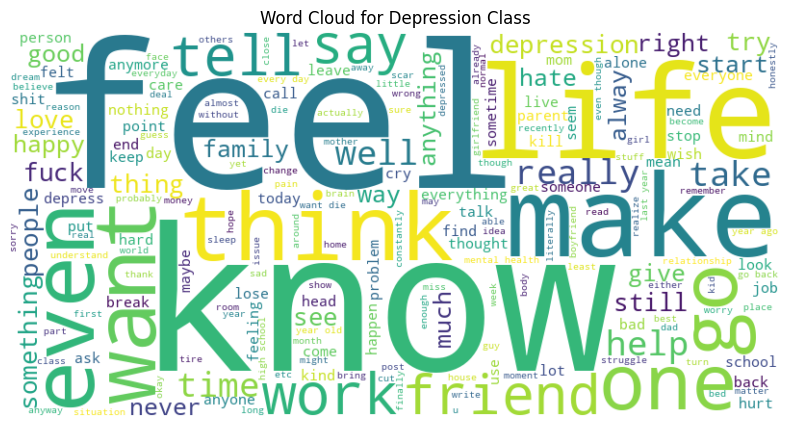

In [ ]:
class_texts = df[df['depression'] == 1]['lemmatized_tokens']
generate_word_cloud(class_texts, f'Word Cloud for Depression Class')

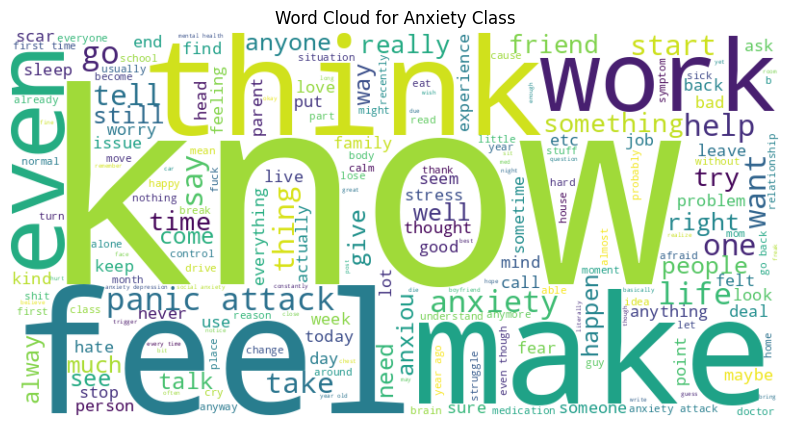

In [ ]:
class_texts = df[df['anxiety'] == 1]['lemmatized_tokens']
generate_word_cloud(class_texts, f'Word Cloud for Anxiety Class')

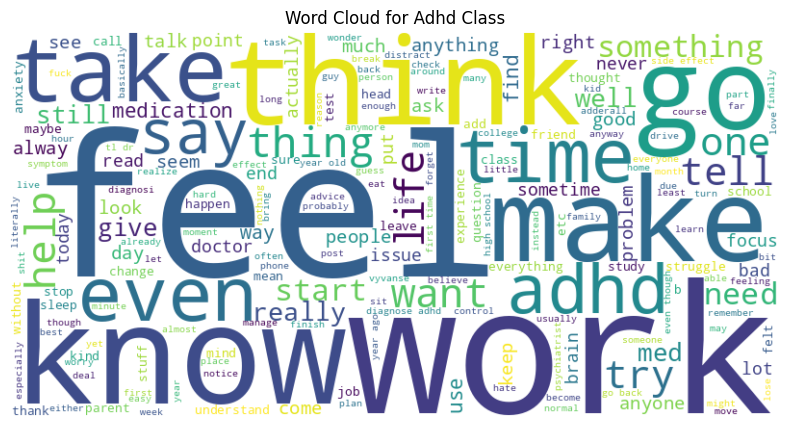

In [ ]:
class_texts = df[df['adhd'] == 1]['lemmatized_tokens']
generate_word_cloud(class_texts, f'Word Cloud for Adhd Class')

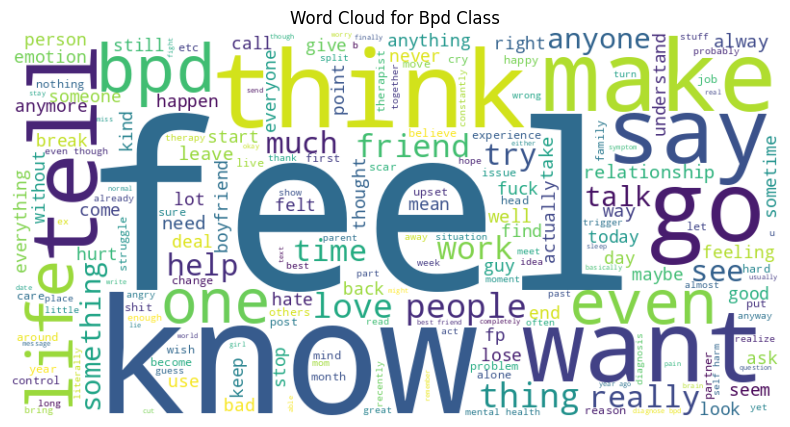

In [ ]:
class_texts = df[df['bpd'] == 1]['lemmatized_tokens']
generate_word_cloud(class_texts, f'Word Cloud for Bpd Class')

## Most frequent words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


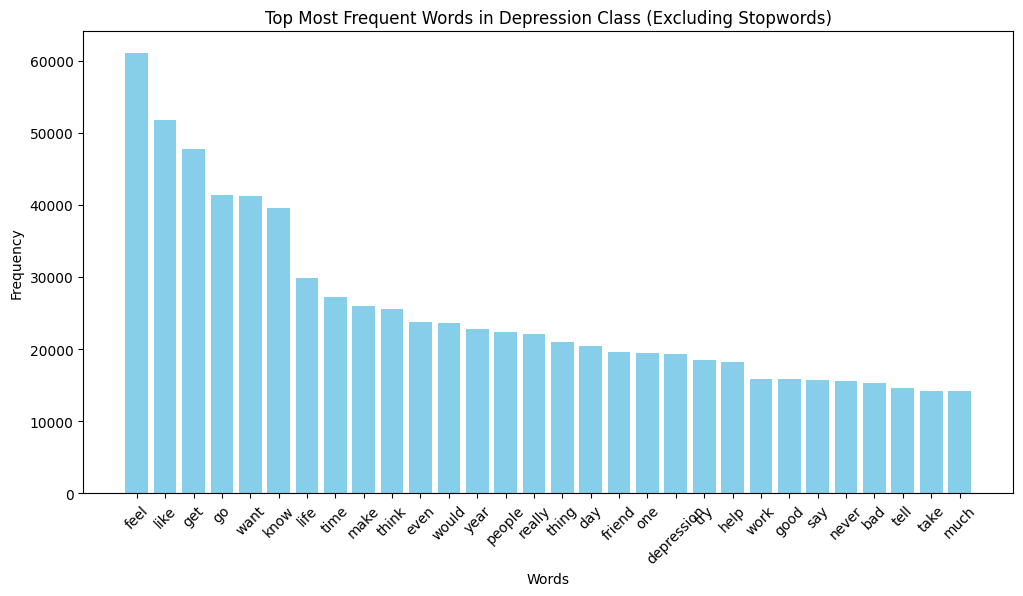

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Download stopwords if not already downloaded
import nltk
nltk.download('stopwords')

# Filter the DataFrame by depression class
depression_texts = df[df['depression'] == 1]['lemmatized_tokens']

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Flatten the list of tokens, filter out stopwords, and count the frequency of each word
all_tokens = [token for sublist in depression_texts for token in sublist if token not in stop_words]
word_freq = Counter(all_tokens)

# Get the most common words (e.g., top 30 most common words)
most_common_words = word_freq.most_common(30)

# Prepare data for plotting
words, frequencies = zip(*most_common_words)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Most Frequent Words in Depression Class (Excluding Stopwords)')
plt.xticks(rotation=45)
plt.show()


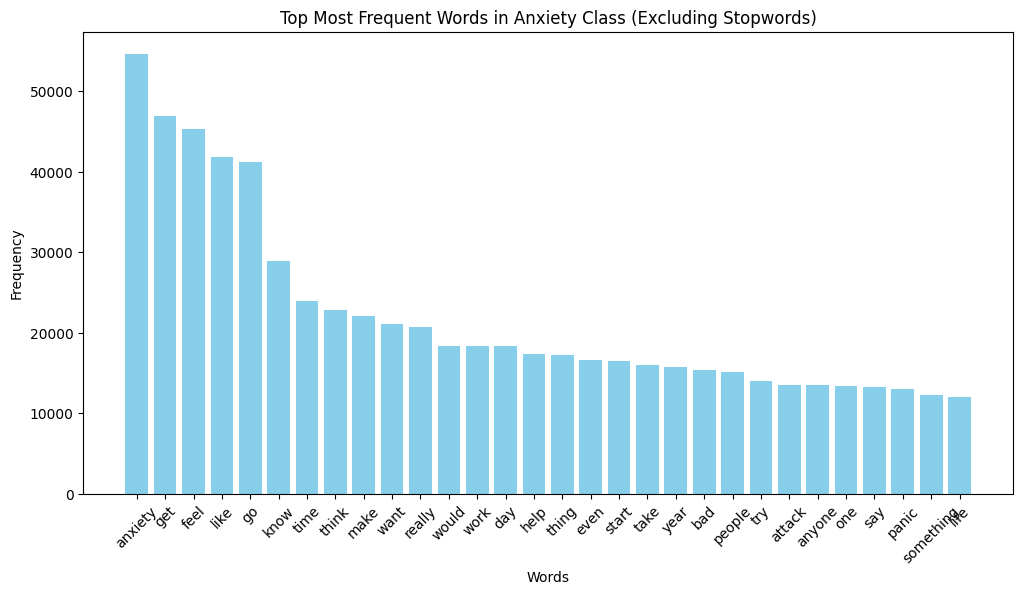

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Filter the DataFrame by anxiety class
anxiety_texts = df[df['anxiety'] == 1]['lemmatized_tokens']

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Flatten the list of tokens, filter out stopwords, and count the frequency of each word
all_tokens = [token for sublist in anxiety_texts for token in sublist if token not in stop_words]
word_freq = Counter(all_tokens)

# Get the most common words (e.g., top 30 most common words)
most_common_words = word_freq.most_common(30)

# Prepare data for plotting
words, frequencies = zip(*most_common_words)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Most Frequent Words in Anxiety Class (Excluding Stopwords)')
plt.xticks(rotation=45)
plt.show()


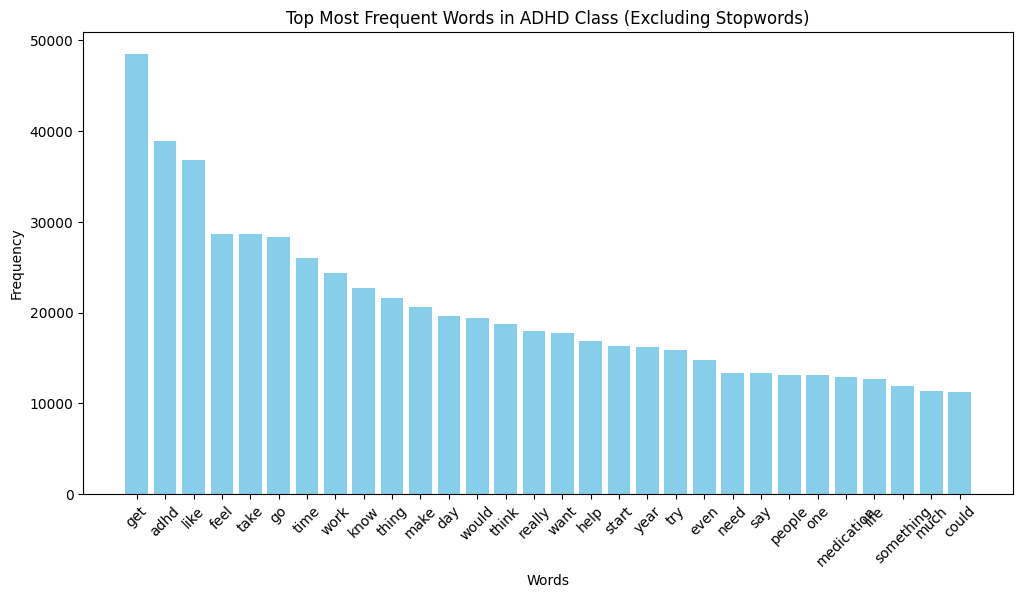

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Filter the DataFrame by ADHD class
adhd_texts = df[df['adhd'] == 1]['lemmatized_tokens']

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Flatten the list of tokens, filter out stopwords, and count the frequency of each word
all_tokens = [token for sublist in adhd_texts for token in sublist if token not in stop_words]
word_freq = Counter(all_tokens)

# Get the most common words (e.g., top 30 most common words)
most_common_words = word_freq.most_common(30)

# Prepare data for plotting
words, frequencies = zip(*most_common_words)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Most Frequent Words in ADHD Class (Excluding Stopwords)')
plt.xticks(rotation=45)
plt.show()


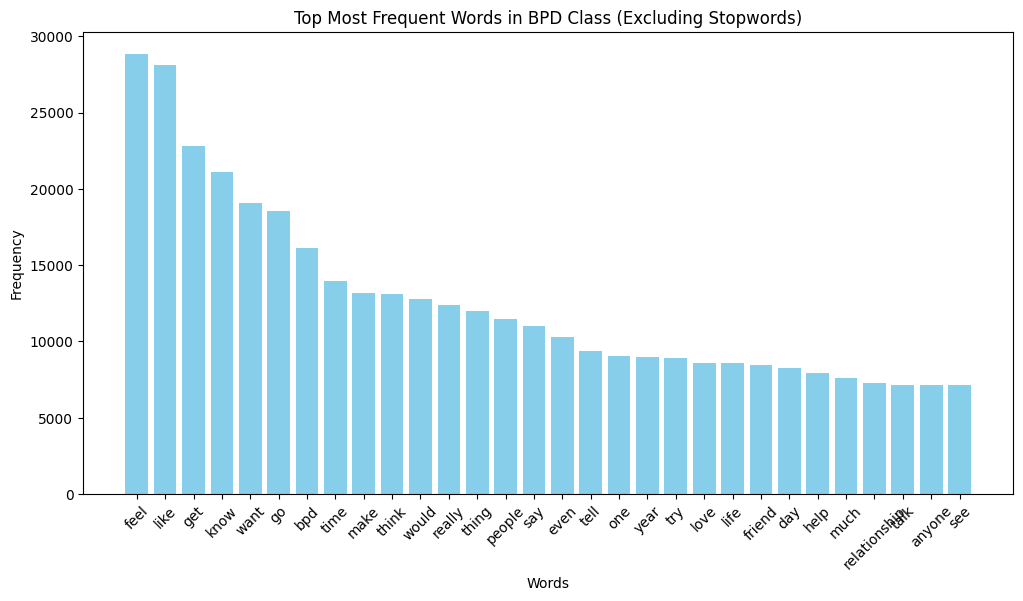

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Filter the DataFrame by BPD class
bpd_texts = df[df['bpd'] == 1]['lemmatized_tokens']

# Get the English stopwords
stop_words = set(stopwords.words('english'))

# Flatten the list of tokens, filter out stopwords, and count the frequency of each word
all_tokens = [token for sublist in bpd_texts for token in sublist if token not in stop_words]
word_freq = Counter(all_tokens)

# Get the most common words (e.g., top 30 most common words)
most_common_words = word_freq.most_common(30)

# Prepare data for plotting
words, frequencies = zip(*most_common_words)

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(words, frequencies, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top Most Frequent Words in BPD Class (Excluding Stopwords)')
plt.xticks(rotation=45)
plt.show()


## extract and count n-grams

In [ ]:
from collections import Counter
from nltk import ngrams

def extract_ngrams(texts, n):
    ngram_list = [ngram for text in texts for ngram in ngrams(text, n)]
    ngram_counts = Counter(ngram_list)
    return ngram_counts.most_common(20)

In [ ]:
# Analysis for the "depression" class
label = 'depression'
class_texts = df[df[label] == 1]['lemmatized_tokens']

top_bigrams = extract_ngrams(class_texts, 2)
top_trigrams = extract_ngrams(class_texts, 3)
top_quadrigrams = extract_ngrams(class_texts, 4)

print(f'Top bigrams for {label.capitalize()} Class:')
for bigram, count in top_bigrams:
    print(f'{bigram}: {count}')

print(f'\nTop trigrams for {label.capitalize()} Class:')
for trigram, count in top_trigrams:
    print(f'{trigram}: {count}')


print('\n' + '='*50 + '\n')

Top bigrams for Depression Class:
('can', 'not'): 25576
('feel', 'like'): 21052
('not', 'know'): 17329
('my', 'life'): 13101
('not', 'want'): 11293
('it', 'not'): 9405
('make', 'me'): 8380
('not', 'even'): 7492
('my', 'friend'): 5895
('tell', 'me'): 5633
('no', 'one'): 5045
('my', 'parent'): 4960
('me', 'feel'): 4707
('my', 'family'): 4562
('not', 'feel'): 4476
('me', 'not'): 4047
('my', 'mom'): 3883
('kill', 'myself'): 3794
('not', 'get'): 3766
('my', 'depression'): 3723

Top trigrams for Depression Class:
('make', 'me', 'feel'): 2994
('it', 'feel', 'like'): 2158
('it', 'make', 'me'): 1916
('can', 'not', 'even'): 1893
('can', 'not', 'get'): 1317
('not', 'feel', 'like'): 1310
('not', 'even', 'know'): 1301
('me', 'feel', 'like'): 1240
('my', 'best', 'friend'): 1118
('feel', 'like', 'it'): 1115
('feel', 'like', 'not'): 1076
('feel', 'like', 'my'): 1050
('not', 'know', 'it'): 1011
('not', 'know', 'anymore'): 987
('my', 'mental', 'health'): 985
('i', 'not', 'know'): 923
('me', 'can', 'not'

In [ ]:
label = 'anxiety'
class_texts = df[df[label] == 1]['lemmatized_tokens']

top_bigrams = extract_ngrams(class_texts, 2)
top_trigrams = extract_ngrams(class_texts, 3)

print(f'Top bigrams for {label.capitalize()} Class:')
for bigram, count in top_bigrams:
    print(f'{bigram}: {count}')

print(f'\nTop trigrams for {label.capitalize()} Class:')
for trigram, count in top_trigrams:
    print(f'{trigram}: {count}')

print('\n' + '='*50 + '\n')

Top bigrams for Anxiety Class:
('can', 'not'): 18029
('feel', 'like'): 15439
('my', 'anxiety'): 11661
('not', 'know'): 11331
('panic', 'attack'): 8831
('it', 'not'): 7547
('make', 'me'): 7405
('my', 'life'): 5893
('not', 'want'): 5760
('anyone', 'else'): 4993
('tell', 'me'): 4263
('not', 'even'): 3981
('think', 'it'): 3493
('could', 'not'): 3415
('my', 'mind'): 3384
('know', 'it'): 3368
('me', 'feel'): 3351
('my', 'head'): 3300
('help', 'me'): 3175
('it', 'my'): 3169

Top trigrams for Anxiety Class:
('make', 'me', 'feel'): 2250
('it', 'make', 'me'): 1850
('it', 'feel', 'like'): 1677
('can', 'not', 'stop'): 1338
('can', 'not', 'even'): 1039
('feel', 'like', 'it'): 995
('feel', 'like', 'my'): 981
('me', 'feel', 'like'): 932
('not', 'know', 'it'): 932
('can', 'not', 'get'): 913
('anyone', 'else', 'experience'): 802
('can', 'not', 'sleep'): 747
('like', 'can', 'not'): 741
('feel', 'like', 'not'): 701
('feel', 'like', 'go'): 697
('can', 'not', 'help'): 662
('not', 'feel', 'like'): 659
('mak

In [ ]:
label = 'adhd'
class_texts = df[df[label] == 1]['lemmatized_tokens']

top_bigrams = extract_ngrams(class_texts, 2)
top_trigrams = extract_ngrams(class_texts, 3)

print(f'Top bigrams for {label.capitalize()} Class:')
for bigram, count in top_bigrams:
    print(f'{bigram}: {count}')

print(f'\nTop trigrams for {label.capitalize()} Class:')
for trigram, count in top_trigrams:
    print(f'{trigram}: {count}')

print('\n' + '='*50 + '\n')

Top bigrams for Adhd Class:
('can', 'not'): 15370
('feel', 'like'): 10908
('it', 'not'): 7327
('not', 'know'): 6707
('my', 'life'): 5845
('make', 'me'): 5332
('tell', 'me'): 3939
('my', 'adhd'): 3875
('not', 'want'): 3872
('help', 'me'): 3827
('take', 'it'): 3637
('anyone', 'else'): 3441
('not', 'even'): 3265
('not', 'get'): 3242
('my', 'brain'): 3071
('it', 'my'): 2961
('could', 'not'): 2949
('my', 'doctor'): 2900
('take', 'my'): 2895
('get', 'my'): 2885

Top trigrams for Adhd Class:
('make', 'me', 'feel'): 1563
('it', 'make', 'me'): 1403
('it', 'feel', 'like'): 1253
('can', 'not', 'get'): 967
('feel', 'like', 'it'): 858
('can', 'not', 'focus'): 850
('take', 'my', 'med'): 795
('can', 'not', 'even'): 705
('my', 'whole', 'life'): 667
('feel', 'like', 'my'): 667
('can', 'not', 'seem'): 631
('it', 'take', 'me'): 630
('anyone', 'else', 'experience'): 611
('me', 'feel', 'like'): 606
('not', 'feel', 'like'): 602
('it', 'seem', 'like'): 575
('not', 'know', 'it'): 568
('you', 'can', 'not'): 53

In [ ]:
label = 'bpd'
class_texts = df[df[label] == 1]['lemmatized_tokens']

top_bigrams = extract_ngrams(class_texts, 2)
top_trigrams = extract_ngrams(class_texts, 3)

print(f'Top bigrams for {label.capitalize()} Class:')
for bigram, count in top_bigrams:
    print(f'{bigram}: {count}')

print(f'\nTop trigrams for {label.capitalize()} Class:')
for trigram, count in top_trigrams:
    print(f'{trigram}: {count}')

print('\n' + '='*50 + '\n')

Top bigrams for Bpd Class:
('feel', 'like'): 10230
('can', 'not'): 10104
('not', 'know'): 7494
('not', 'want'): 4965
('it', 'not'): 4438
('my', 'life'): 4074
('tell', 'me'): 4004
('make', 'me'): 3930
('not', 'even'): 2751
('he', 'not'): 2616
('anyone', 'else'): 2605
('me', 'feel'): 2408
('me', 'not'): 2182
('know', 'it'): 2059
('my', 'friend'): 1945
('my', 'boyfriend'): 1938
('me', 'he'): 1914
('it', 'feel'): 1832
('me', 'it'): 1774
('she', 'not'): 1695

Top trigrams for Bpd Class:
('make', 'me', 'feel'): 1490
('it', 'make', 'me'): 1042
('it', 'feel', 'like'): 1033
('me', 'feel', 'like'): 724
('can', 'not', 'stop'): 632
('he', 'tell', 'me'): 630
('my', 'best', 'friend'): 613
('tell', 'me', 'he'): 562
('feel', 'like', 'it'): 543
('she', 'tell', 'me'): 517
('not', 'know', 'it'): 508
('he', 'say', 'he'): 503
('not', 'feel', 'like'): 502
('feel', 'like', 'my'): 502
('not', 'even', 'know'): 494
('can', 'not', 'help'): 494
('my', 'mental', 'health'): 491
('can', 'not', 'even'): 488
('can', '

## Vocabulary Analysis

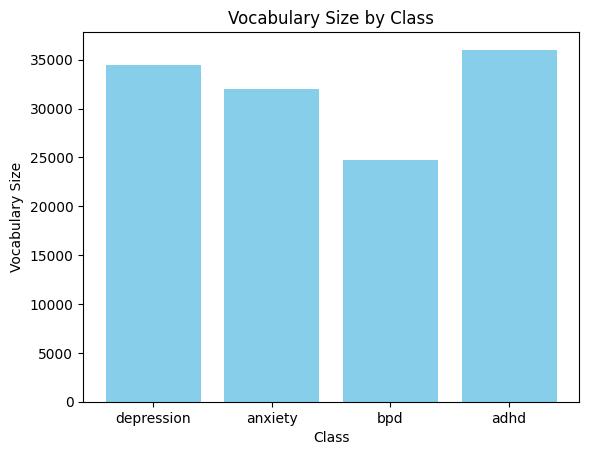

In [ ]:
vocab_size = {
    label: len(set([word for text in df[df[label] == 1]['lemmatized_tokens'] for word in text]))
    for label in ['depression', 'anxiety', 'bpd', 'adhd']
}

plt.bar(vocab_size.keys(), vocab_size.values(), color='skyblue')
plt.xlabel('Class')
plt.ylabel('Vocabulary Size')
plt.title('Vocabulary Size by Class')
plt.show()


In [ ]:
# Print the values
for label, size in vocab_size.items():
    print(f'Vocabulary size for {label.capitalize()} class: {size}')


Vocabulary size for Depression class: 34472
Vocabulary size for Anxiety class: 31967
Vocabulary size for Bpd class: 24755
Vocabulary size for Adhd class: 36018


## TF-IDF Analysis

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords

# Define English stopwords as a list
stop_words = stopwords.words('english')

# Initialize TF-IDF vectorizer with stopwords removed
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)

# Iterate over each label
for label in ['depression', 'anxiety', 'bpd', 'adhd']:
    # Filter texts by class label
    class_texts = df[df[label] == 1]['tokens_back_to_text']

    # Compute TF-IDF matrix
    tfidf_matrix = tfidf_vectorizer.fit_transform(class_texts)

    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()

    # Compute TF-IDF scores
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    # Get top 10 TF-IDF words
    tfidf_rankings = sorted(zip(tfidf_scores, feature_names), reverse=True)[:30]

    # Print results
    print(f'Top 10 TF-IDF words for {label.capitalize()} Class: {tfidf_rankings}')


Top 10 TF-IDF words for Depression Class: [(2185.62685370957, 'feel'), (1802.1808421850897, 'like'), (1661.419175940754, 'want'), (1640.4318937962616, 'get'), (1508.9928812704572, 'know'), (1483.773523900247, 'go'), (1255.4675238248321, 'life'), (1101.5279739599541, 'think'), (1082.6534911093997, 'time'), (1067.3430509058, 'make'), (1042.1602498586165, 'people'), (1037.7476917248416, 'really'), (1015.8780298683749, 'even'), (999.4481141273769, 'would'), (996.6347105803683, 'depression'), (984.9663069935975, 'year'), (968.99809451358, 'friend'), (968.8214309183345, 'help'), (960.1705749215248, 'day'), (932.8579309944325, 'thing'), (893.074310977746, 'one'), (868.8235321329503, 'try'), (801.5268970082086, 'good'), (794.750294085643, 'bad'), (786.935938530167, 'work'), (783.9835463489891, 'fuck'), (781.813132401153, 'talk'), (765.8590723923843, 'say'), (763.5483979719896, 'never'), (748.984343281432, 'tell')]
Top 10 TF-IDF words for Anxiety Class: [(1845.7645899430863, 'anxiety'), (1655.8

## occurrences of target words in diff classes

In [ ]:
import pandas as pd

# Define the labels and the words to count
labels = ['depression', 'anxiety', 'bpd', 'adhd']
words_to_count = ['depression', 'anxiety', 'adhd', 'bpd']

# Initialize a dictionary to store the counts for each label
word_counts = {label: {word: 0 for word in words_to_count} for label in labels}

# Iterate over each label
for label in labels:
    # Filter the DataFrame for the current label
    class_texts = df[df[label] == 1]['tokens_back_to_text']

    # Count the occurrences of each word in the filtered text
    for text in class_texts:
        for word in words_to_count:
            word_counts[label][word] += text.split().count(word)

# Print the counts for each label
for label, counts in word_counts.items():
    print(f"Counts for {label}:")
    for word, count in counts.items():
        print(f"  {word}: {count}")


Counts for depression:
  depression: 19309
  anxiety: 6020
  adhd: 378
  bpd: 135
Counts for anxiety:
  depression: 3993
  anxiety: 54622
  adhd: 415
  bpd: 68
Counts for bpd:
  depression: 1794
  anxiety: 2516
  adhd: 274
  bpd: 16144
Counts for adhd:
  depression: 3868
  anxiety: 6600
  adhd: 38888
  bpd: 118


In [ ]:
# Find terms that overlap between classes
overlapping_terms = {}
for label in ['depression', 'anxiety', 'adhd', 'bpd']:
    # Flatten the list of tokens into a single string
    text = ' '.join([' '.join(tokens) for tokens in df[df[label] == 1]['tokens']])
    tokens = set(text.split())
    overlapping_terms[label] = tokens

# Find the intersection of terms across all classes
overlap = overlapping_terms['depression'] & overlapping_terms['anxiety'] & overlapping_terms['adhd'] & overlapping_terms['bpd']
print("Overlapping terms across all classes:", overlap)


Overlapping terms across all classes: {'assaulting', 'euphoria', 'evolved', 'gaming', 'separating', 'snowballed', 'disapproval', 'disassociation', 'lifted', 'bam', 'envision', 'aged', 'infuriating', 'supporting', 'fixated', 'comedian', 'tact', 'decorated', 'globe', 'described', 'abstract', 'blindsided', 'capitalist', 'burnt', 'heater', 'caving', 'appealed', 'truer', 'ensure', 'teenage', 'thud', 'retroactively', 'roomates', 'asd', 'lagging', 'pressurized', 'stabilizers', 'eight', 'motionless', 'disfunction', 'violence', 'educational', 'basics', 'kfc', 'stoked', 'misinterpreting', 'learnt', 'bastards', 'lover', 'gigs', 'spouts', 'striking', 'spew', 'harvey', 'tablets', 'technician', 'propel', 'likeminded', 'surgeries', 'bike', 'seamless', 'enable', 'essence', 'band', 'exchange', 'diseases', 'fixes', 'weddings', 'edibles', 'praised', 'suppressed', 'meandering', 'sclerosis', 'memories', 'passengers', 'condescending', 'papa', 'discourse', 'pusher', 'dermatologists', 'shat', 'trophy', 'giggl

In [ ]:
multi_label_posts = df[(df[['depression', 'anxiety', 'adhd', 'bpd']].sum(axis=1) > 1)]
print("Number of multi-label posts:", multi_label_posts.shape[0])


Number of multi-label posts: 0


# class specific data pre processing

In [ ]:
df = pd.read_json('/content/drive/MyDrive/pfa/final_tokenized_reddits_lemmetized.json', orient='table')

In [ ]:
# Check the class distribution
class_distribution = df['depression'].value_counts()
print(class_distribution)

depression
0    90604
1    37961
Name: count, dtype: int64


In [ ]:
!pip install nlpaug


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 8.6 MB/s eta 0:00:00


In [ ]:
# Check for NaN values in 'lemmatized_tokens' column
print("NaN values in 'lemmatized_tokens':", df['lemmatized_tokens'].isna().sum())

NaN values in 'lemmatized_tokens': 0


In [ ]:
import pandas as pd
from nltk.corpus import wordnet
import random

# Function for synonym replacement
def synonym_replacement(tokens):
    augmented_tokens = []
    for token in tokens:
        synsets = wordnet.synsets(token)
        if synsets:
            synonyms = [lemma.name() for synset in synsets for lemma in synset.lemmas()]
            synonym = random.choice(synonyms)
            augmented_tokens.append(synonym)
        else:
            augmented_tokens.append(token)
    return augmented_tokens

# Apply data augmentation to balance the class distribution
def augment_data(df):
    # Identify the minority class (depression = 1)
    minority_class_label = 1

    # Get the data for the minority class
    minority_data = df[df['depression'] == minority_class_label]

    # Define the number of samples you want to augment
    num_samples_to_augment = len(df) - len(minority_data)

    # Augment the data to balance the class distribution
    augmented_samples = []
    for index, row in minority_data.iterrows():
        lemmatized_tokens = row['lemmatized_tokens']
        # Apply augmentation to tokens
        augmented_tokens = synonym_replacement(lemmatized_tokens)
        # Convert augmented tokens back to text
        augmented_text = ' '.join(augmented_tokens)
        # Append augmented sample to the list
        augmented_samples.append({'tokens_back_to_text': augmented_text, 'depression': minority_class_label})

    # Convert the list of augmented samples to a DataFrame
    augmented_df = pd.DataFrame(augmented_samples)

    # Concatenate the augmented data with the original dataset
    balanced_df = pd.concat([df, augmented_df], ignore_index=True)

    # Shuffle the DataFrame to ensure randomness
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return balanced_df

In [ ]:
import nltk

# Download the WordNet corpus
nltk.download('wordnet')

# You may also need to download the 'omw-1.4' data for additional language support
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Apply data augmentation
augmented_df = augment_data(df)

In [ ]:
# Check for NaN values in 'tokens_back_to_text' column
print(augmented_df['tokens_back_to_text'].isna().sum())

0


In [ ]:
augmented_df.shape

(166526, 9)

In [ ]:
augmented_df.head()

,label,text,depression,anxiety,bpd,adhd,tokens,lemmatized_tokens,tokens_back_to_text
0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1 not tone anything anymore iodin no_more grou...
1,depression,i cannot keep fight left me really not strengt...,1,0.0,0.0,0.0,"[i, can, not, keep, fight, left, me, really, n...","[i, can, not, keep, fight, left, me, really, n...",i can not keep fight left me really not streng...
2,adhd,you success self studying computer certificati...,0,0.0,0.0,1.0,"[you, success, self, studying, computer, certi...","[you, success, self, study, computer, certific...",you success self study computer certification ...
3,bpd,difficulties job searching bpd anybody else st...,0,0.0,1.0,0.0,"[difficulties, job, searching, bpd, anybody, e...","[difficulty, job, search, bpd, anybody, else, ...",difficulty job search bpd anybody else struggl...
4,anxiety,i something wrong me everyday anxiety mostly r...,0,1.0,0.0,0.0,"[i, something, wrong, me, everyday, anxiety, m...","[i, something, wrong, me, everyday, anxiety, m...",i something wrong me everyday anxiety mostly r...


In [ ]:
# Check the class distribution after augmentation
class_distribution = augmented_df['depression'].value_counts()
print(class_distribution)

depression
0    90604
1    75922
Name: count, dtype: int64


In [ ]:
# Save the augmented DataFrame to a CSV file
augmented_df.to_json('/content/drive/MyDrive/pfa/augmented_depression_data.json', orient='table', index=False)

In [ ]:
# Check for NaN values in 'tokens_back_to_text' column
print(augmented_df['tokens_back_to_text'].isna().sum())

0


# Deep learning models

In [ ]:
df = pd.read_json('/content/drive/MyDrive/pfa/augmented_depression_data.json', orient='table')


reddits = list(df['tokens_back_to_text'])
type(reddits)

list

In [ ]:
# Check for NaN values in 'tokens_back_to_text' column
print(df['tokens_back_to_text'].isna().sum())

0


In [ ]:
len(reddits)

166526

In [ ]:
df['index'] = df.index

In [ ]:
df.head()

,label,text,depression,anxiety,bpd,adhd,tokens,lemmatized_tokens,tokens_back_to_text,index
0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1 not tone anything anymore iodin no_more grou...,0
1,depression,i cannot keep fight left me really not strengt...,1,0.0,0.0,0.0,"[i, can, not, keep, fight, left, me, really, n...","[i, can, not, keep, fight, left, me, really, n...",i can not keep fight left me really not streng...,1
2,adhd,you success self studying computer certificati...,0,0.0,0.0,1.0,"[you, success, self, studying, computer, certi...","[you, success, self, study, computer, certific...",you success self study computer certification ...,2
3,bpd,difficulties job searching bpd anybody else st...,0,0.0,1.0,0.0,"[difficulties, job, searching, bpd, anybody, e...","[difficulty, job, search, bpd, anybody, else, ...",difficulty job search bpd anybody else struggl...,3
4,anxiety,i something wrong me everyday anxiety mostly r...,0,1.0,0.0,0.0,"[i, something, wrong, me, everyday, anxiety, m...","[i, something, wrong, me, everyday, anxiety, m...",i something wrong me everyday anxiety mostly r...,4


## Feature Extraction

### Tokenization

In [ ]:
from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(reddits)


In [ ]:
word_index = tokenizer.word_index

print('WE HAVE %s UNIQUE TOKENS.' % len(word_index))

WE HAVE 72600 UNIQUE TOKENS.


In [ ]:
sequences = tokenizer.texts_to_sequences(reddits)

In [ ]:
# Calculate the length of each sequence
sequence_lengths = [len(seq) for seq in sequences]

# Calculate the average sequence length
average_length = np.mean(sequence_lengths)
max_length = np.max(sequence_lengths)
min_length = np.min(sequence_lengths)

print('WE HAVE %s UNIQUE TOKENS.' % len(word_index))
print('AVERAGE SEQUENCE LENGTH: %.2f' % average_length)
print('MAXIMUM SEQUENCE LENGTH: %d' % max_length)
print('MINIMUM SEQUENCE LENGTH: %d' % min_length)

WE HAVE 72600 UNIQUE TOKENS.
AVERAGE SEQUENCE LENGTH: 102.76
MAXIMUM SEQUENCE LENGTH: 3185
MINIMUM SEQUENCE LENGTH: 0


In [ ]:
# Calculate the percentage of sequences with length <= 250
maxlen = 350
num_sequences_covered = sum(1 for length in sequence_lengths if length <= maxlen)
percentage_covered = (num_sequences_covered / len(sequence_lengths)) * 100

print('PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH %d: %.2f%%' % (maxlen, percentage_covered))


PERCENTAGE OF SEQUENCES COVERED BY MAX LENGTH 350: 97.28%


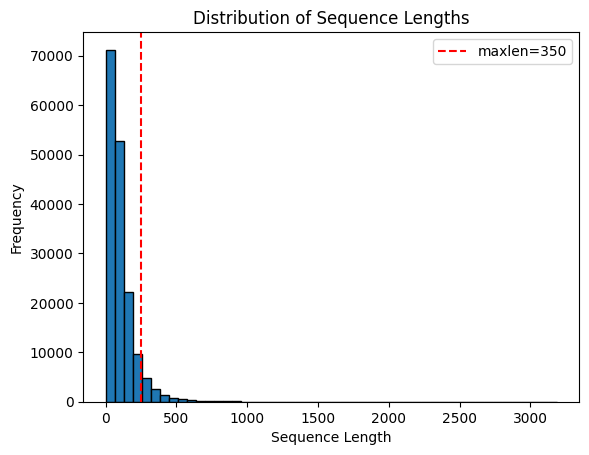

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50, edgecolor='k')
plt.axvline(x=250, color='r', linestyle='--', label='maxlen=350')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.legend()
plt.show()

In [ ]:
X = pad_sequences(sequences, maxlen = maxlen)
X.shape

(166526, 350)

In [ ]:
y = df['depression']

In [ ]:
indices = df['index']

## Split the dataset into training and test sets

In [ ]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, indices, test_size=0.2, random_state=43)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape ,indices_train.shape, indices_test.shape


((133220, 350), (33306, 350), (133220,), (33306,), (133220,), (33306,))

In [ ]:
# Save the datasets as .npy files
np.save('/content/drive/MyDrive/pfa/depression_X_train.npy', X_train)
np.save('/content/drive/MyDrive/pfa/depression_X_test.npy', X_test)
np.save('/content/drive/MyDrive/pfa/depression_y_train.npy', y_train)
np.save('/content/drive/MyDrive/pfa/depression_y_test.npy', y_test)
np.save('/content/drive/MyDrive/pfa/depression_indices_train.npy', indices_train)
np.save('/content/drive/MyDrive/pfa/depression_indices_test.npy', indices_test)

In [ ]:
y_train_0 = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_0 = np.asarray(y_test).astype('float32').reshape((-1,1))

## Embedding Layer

In [ ]:
import gensim.downloader as api
import numpy as np

# Load pre-trained FastText model
fasttext_model = api.load('fasttext-wiki-news-subwords-300')

In [ ]:
# Load pre-trained GloVe model (Twitter dataset)
glove_model = api.load('glove-twitter-100')

In [ ]:
# Load pre-trained Word2Vec model
word2vec_model = api.load('word2vec-google-news-300')

In [ ]:
def create_embedding_matrix(tokenizer, embedding_model):
    """Create embedding matrix from pre-trained word embedding model."""
    vocab_size = len(tokenizer.word_index)
    embedding_dim = len(embedding_model['king'])  # Assuming 'king' is in the model vocabulary

    # Initialize embedding matrix
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))

    # Fill embedding matrix
    for word, i in tokenizer.word_index.items():
        if word in embedding_model:
            embedding_matrix[i] = embedding_model[word]
        else:
            # Initialize random vector for out-of-vocabulary words
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))

    return embedding_matrix


In [ ]:
# Use these models to create embedding matrices for your tokenizer
embedding_matrix_fasttext = create_embedding_matrix(tokenizer, fasttext_model)

In [ ]:
embedding_matrix_glove = create_embedding_matrix(tokenizer, glove_model)


In [ ]:
embedding_matrix_word2vec = create_embedding_matrix(tokenizer, word2vec_model)

In [ ]:
import os
import numpy as np

# Define directory path for saving the embedding matrices
embedding_directory = '/content/drive/MyDrive/pfa/embedding_matrix/'

# Create the directory if it doesn't exist
os.makedirs(embedding_directory, exist_ok=True)

In [ ]:
fasttext_embedding_path = os.path.join(embedding_directory, 'depression_fasttext_embedding_matrix.npy')
np.save(fasttext_embedding_path, embedding_matrix_fasttext)

In [ ]:
glove_embedding_path = os.path.join(embedding_directory, 'depression_glove_embedding_matrix.npy')
np.save(glove_embedding_path, embedding_matrix_glove)

In [ ]:
word2vec_embedding_path = os.path.join(embedding_directory, 'depression_word2vec_embedding_matrix.npy')
np.save(word2vec_embedding_path, embedding_matrix_word2vec)

## Defining the Convolutional Neural Network Model

In [ ]:
vocab_size = len(tokenizer.word_index) + 1


In [ ]:
embedding_path='/content/drive/MyDrive/pfa/embedding_matrix/depression_fasttext_embedding_matrix.npy'
embedding_matrix=np.load(embedding_path)
embedding_dim = embedding_matrix.shape[1]
vocab_size = embedding_matrix.shape[0]

print(embedding_dim)

In [ ]:
cnn_model = Sequential()

# Embedding layer
cnn_model.add(Embedding(input_dim=vocab_size,
                    output_dim= embedding_dim,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False))

# Convolutional layers
cnn_model.add(Conv1D(128, 3, padding='same', activation='relu'))
cnn_model.add(Conv1D(64, 3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())

# Flatten and Dense layers
cnn_model.add(Flatten())
cnn_model.add(Dense(250, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


### Visualizing the CNN Model

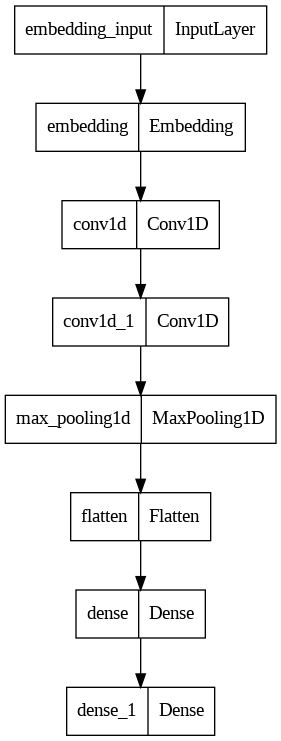

In [ ]:
plot_model(cnn_model)


In [ ]:
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 300)          22150200  
                                                                 
 conv1d (Conv1D)             (None, 150, 128)          115328    
                                                                 
 conv1d_1 (Conv1D)           (None, 150, 64)           24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 75, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 4800)              0         
                                                                 
 dense (Dense)               (None, 250)               1200250   
                                                        

In [ ]:
# Train the model
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
3331/3331 [==============================] - 37s 10ms/step - loss: 0.2631 - accuracy: 0.8840 - val_loss: 0.2233 - val_accuracy: 0.9067
Epoch 2/10
3331/3331 [==============================] - 30s 9ms/step - loss: 0.1997 - accuracy: 0.9160 - val_loss: 0.2104 - val_accuracy: 0.9123
Epoch 3/10
3331/3331 [==============================] - 26s 8ms/step - loss: 0.1758 - accuracy: 0.9263 - val_loss: 0.2338 - val_accuracy: 0.9072
Epoch 4/10
3331/3331 [==============================] - 24s 7ms/step - loss: 0.1539 - accuracy: 0.9355 - val_loss: 0.2359 - val_accuracy: 0.9112
Epoch 5/10
3331/3331 [==============================] - 27s 8ms/step - loss: 0.1313 - accuracy: 0.9459 - val_loss: 0.2558 - val_accuracy: 0.9095
Epoch 6/10
3331/3331 [==============================] - 26s 8ms/step - loss: 0.1146 - accuracy: 0.9538 - val_loss: 0.2595 - val_accuracy: 0.9109
Epoch 7/10
3331/3331 [==============================] - 24s 7ms/step - loss: 0.0935 - accuracy: 0.9632 - val_loss: 0.3277 - val_a

In [ ]:
# Save the entire model to a single HDF5 file
cnn_model.save("/content/drive/MyDrive/pfa/models/depression_cnn_model_fasttext_350.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluation


In [ ]:
# Evaluate the model
score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


1041/1041 [==============================] - 4s 4ms/step - loss: 0.5260 - accuracy: 0.8987
Test Score: 0.5260372757911682
Test Accuracy: 0.8986969590187073


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Make predictions
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate Precision
precision = precision_score(y_test, y_pred_classes)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred_classes)
print("Recall:", recall)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_classes)
print("F1 Score:", f1)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)

1041/1041 [==============================] - 2s 2ms/step
Precision: 0.8657805255023184
Recall: 0.9208916946143223
F1 Score: 0.8924861385507615
ROC-AUC: 0.9654476931533412


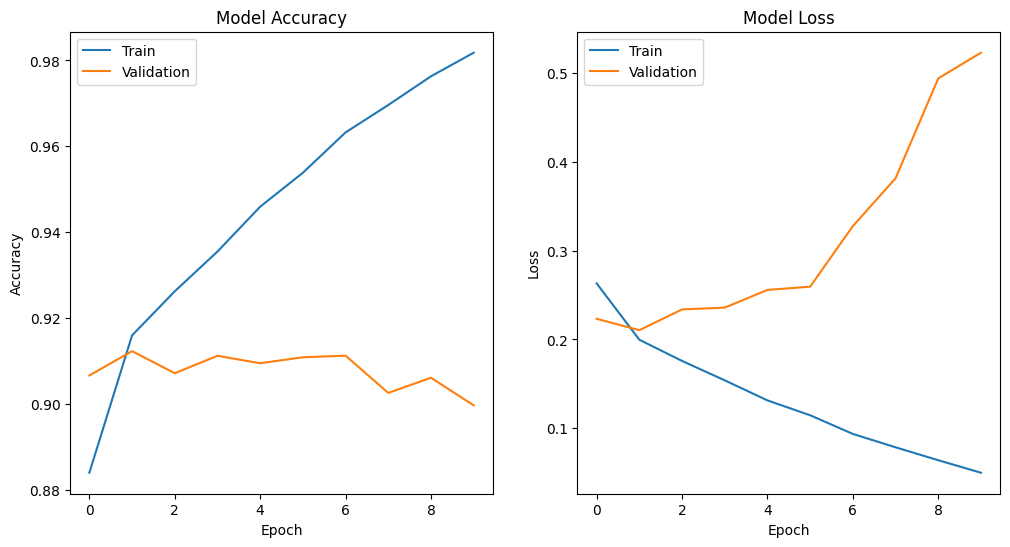

In [ ]:
# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Show plots
plt.show()


### Confusion matrix


In [ ]:
!pip install tensorflow scikit-learn


In [ ]:
from keras.models import load_model

# Load the model
cnn_model = load_model("/content/drive/MyDrive/pfa/models/depression_cnn_model_fasttext.h5")


In [ ]:
import numpy as np
import tensorflow as tf

# Load the test dataset
X_test = np.load('/content/drive/MyDrive/pfa/depression_X_test.npy')

In [ ]:
# Make predictions
y_pred_prob_cnn = cnn_model.predict(X_test)
# Convert probabilities to class labels
y_pred_cnn = (y_pred_prob_cnn > 0.5).astype(int)


1041/1041 [==============================] - 2s 2ms/step


In [ ]:
# Save the predictions
np.save('/content/drive/MyDrive/pfa/depression_y_pred_cnn_fasttext.npy', y_pred_cnn)

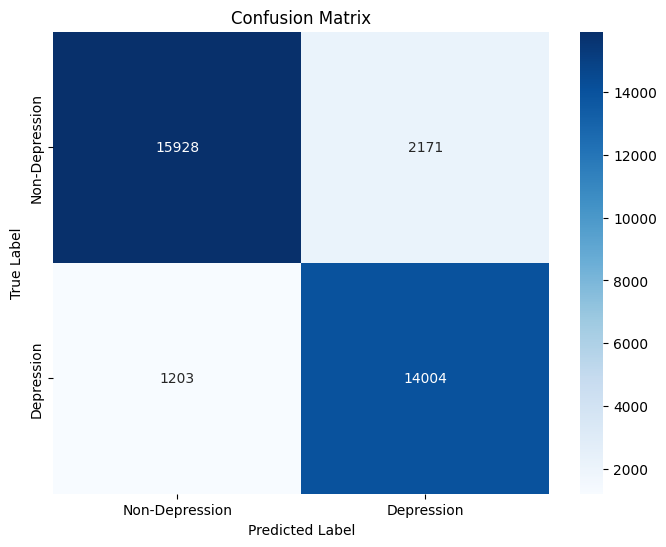

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)

# Define class labels
class_labels = ['Non-Depression', 'Depression']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Calculate total number of samples
total_samples = cm.sum()

# Extract values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate percentages
tn_percentage = (tn / total_samples) * 100
fp_percentage = (fp / total_samples) * 100
fn_percentage = (fn / total_samples) * 100
tp_percentage = (tp / total_samples) * 100

# Print the confusion matrix with percentages
print("Confusion Matrix (Percentages):")
print(f"True Negative (Non-Depression correctly identified): {tn_percentage:.2f}%")
print(f"False Positive (Non-Depression misclassified as Depression): {fp_percentage:.2f}%")
print(f"False Negative (Depression misclassified as Non-Depression): {fn_percentage:.2f}%")
print(f"True Positive (Depression correctly identified): {tp_percentage:.2f}%")


Confusion Matrix (Percentages):
True Negative (Non-Depression correctly identified): 47.82%
False Positive (Non-Depression misclassified as Depression): 6.52%
False Negative (Depression misclassified as Non-Depression): 3.61%
True Positive (Depression correctly identified): 42.05%


In [ ]:
# Convert y_test and y_pred to NumPy arrays if they are not already
y_test = np.array(y_test)
y_pred = np.array(y_pred_cnn).reshape(-1)


In [ ]:
# Verify the lengths of y_test, y_pred, and X_test
assert len(y_test) == len(y_pred), "Length of y_test and y_pred must be the same"
assert len(y_test) == len(X_test), "Length of y_test and X_test must be the same"


In [ ]:
# Ensure that y_test and y_pred are binary
assert set(np.unique(y_test)).issubset({0, 1}), "y_test should only contain binary values 0 and 1"
assert set(np.unique(y_pred)).issubset({0, 1}), "y_pred should only contain binary values 0 and 1"


In [ ]:
# Debugging: Print the shapes and unique values
print(f"y_test shape: {y_test.shape}, unique values: {np.unique(y_test)}")
print(f"y_pred shape: {y_pred.shape}, unique values: {np.unique(y_pred)}")


y_test shape: (33306,), unique values: [0 1]
y_pred shape: (33306,), unique values: [0 1]


In [ ]:
# Find the indices of false negatives
false_negatives_indices = np.flatnonzero((y_test == 1) & (y_pred == 0))

# Debugging: Print the number of false negatives and a few indices
print(f"Number of false negatives: {len(false_negatives_indices)}")
print(f"First few false negative indices: {false_negatives_indices[:10]}")



Number of false negatives: 1203
First few false negative indices: [ 61 127 132 139 146 174 211 216 243 267]


In [ ]:
# Limit the number of samples to display to avoid overwhelming the session
num_samples_to_display = min(5, len(false_negatives_indices))  # Adjust the number as needed

# Assuming df is the original DataFrame containing 'text' and 'tokens' columns
for i in range(num_samples_to_display):
    test_index = false_negatives_indices[i]
    original_index = indices_test[test_index]  # Get the original index from the test set
    try:
        # Retrieve the text and tokens from the DataFrame
        text = df.loc[original_index, 'text']
        tokens = df.loc[original_index, 'tokens_back_to_text']
        print(f"Sample {i+1}:")
        print(f"Text: {text}")
        print(f"Tokens: {tokens}")
    except IndexError as e:
        print(f"IndexError for index {original_index}: {e}")

Sample 1:
Text: people still hate me even reddit not able make one post comment anything last months without people making random snarky critical replies get completely downvoted people upvoted look like they right still not know threads asking advice help know it reddit know it internet people making exact snarky critical comments get everyday life ones make me crawl back hiding every time try put myself repeat repeat point it like emanate terrible provoking aura whether sitting next someone train oceans apart behind computer screen
Tokens: people still hate me even reddit not able make one post comment anything last month without people make random snarky critical reply get completely downvoted people upvoted look like they right still not know thread ask advice help know it reddit know it internet people make exact snarky critical comment get everyday life one make me crawl back hide every time try put myself repeat repeat point it like emanate terrible provoke aura whether sit next

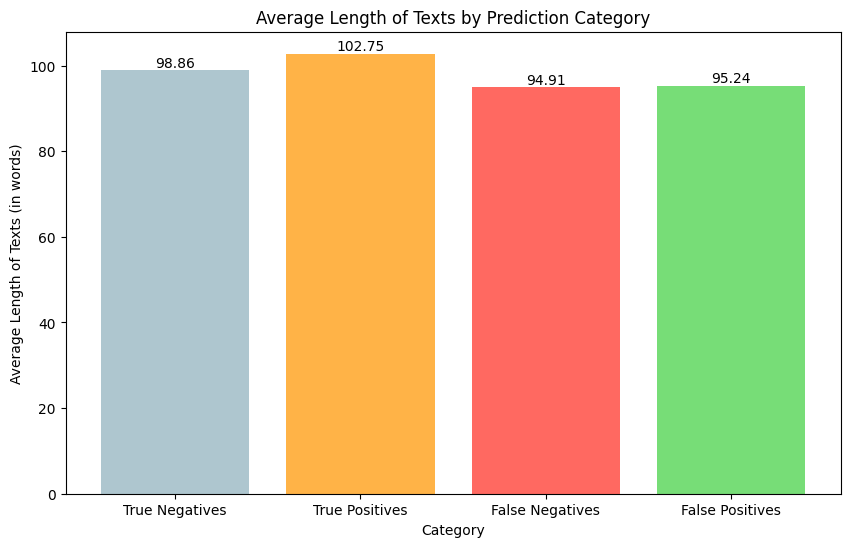

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test, y_pred, df, and indices_test are already defined
true_negatives_indices = np.where((y_test == 0) & (y_pred == 0))[0]
true_positives_indices = np.where((y_test == 1) & (y_pred == 1))[0]
false_negatives_indices = np.where((y_test == 1) & (y_pred == 0))[0]
false_positives_indices = np.where((y_test == 0) & (y_pred == 1))[0]

def calculate_lengths(indices, df):
    lengths = []
    for idx in indices:
        original_index = indices_test[idx]
        try:
            text = df.loc[original_index, 'tokens_back_to_text']
            lengths.append(len(text.split()))  # Calculate length by number of words
        except IndexError as e:
            print(f"IndexError for index {original_index}: {e}")
    return lengths

true_negatives_lengths = calculate_lengths(true_negatives_indices, df)
true_positives_lengths = calculate_lengths(true_positives_indices, df)
false_negatives_lengths = calculate_lengths(false_negatives_indices, df)
false_positives_lengths = calculate_lengths(false_positives_indices, df)

avg_lengths = {
    'True Negatives': np.mean(true_negatives_lengths),
    'True Positives': np.mean(true_positives_lengths),
    'False Negatives': np.mean(false_negatives_lengths),
    'False Positives': np.mean(false_positives_lengths),
}

categories = list(avg_lengths.keys())
values = list(avg_lengths.values())

# Define pastel colors
colors = ['#AEC6CF', '#FFB347', '#FF6961', '#77DD77']

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=colors)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Average Length of Texts (in words)')
plt.title('Average Length of Texts by Prediction Category')
plt.show()


## BiLSTM model

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
embedding_path='/content/drive/MyDrive/pfa/embedding_matrix/depression_fasttext_embedding_matrix.npy'
embedding_matrix=np.load(embedding_path)
embedding_dim = embedding_matrix.shape[1]
vocab_size = embedding_matrix.shape[0]
print(embedding_dim)
print(embedding_matrix.shape[0])

300
72601


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense

# Define the model
Bilstm_model = Sequential()

# Add embedding layer
Bilstm_model.add(Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=maxlen,
                                trainable=False))

# Add Bidirectional LSTM layers
Bilstm_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
Bilstm_model.add(Bidirectional(LSTM(units=64)))

# Add Dense layer
Bilstm_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
Bilstm_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print model summary
Bilstm_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 350, 300)          21780300  
                                                                 
 bidirectional_2 (Bidirecti  (None, 350, 256)          439296    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               164352    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 22384077 (85.39 MB)
Trainable params: 603777 (2.30 MB)
Non-trainable params: 21780300 (83.09 MB)
_________________________________________________________________


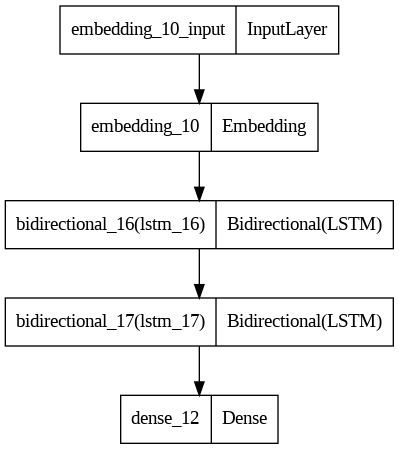

In [ ]:
plot_model(Bilstm_model)


In [ ]:
# Train the model
history = Bilstm_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
3331/3331 [==============================] - 225s 63ms/step - loss: 0.4349 - accuracy: 0.8000 - val_loss: 0.3379 - val_accuracy: 0.8614
Epoch 2/10
3331/3331 [==============================] - 182s 55ms/step - loss: 0.2936 - accuracy: 0.8734 - val_loss: 0.2603 - val_accuracy: 0.8899
Epoch 3/10
3331/3331 [==============================] - 182s 55ms/step - loss: 0.2397 - accuracy: 0.8962 - val_loss: 0.2269 - val_accuracy: 0.9035
Epoch 4/10
3331/3331 [==============================] - 182s 55ms/step - loss: 0.2124 - accuracy: 0.9086 - val_loss: 0.2189 - val_accuracy: 0.9084
Epoch 5/10
3331/3331 [==============================] - 187s 56ms/step - loss: 0.1955 - accuracy: 0.9172 - val_loss: 0.2136 - val_accuracy: 0.9125
Epoch 6/10
3331/3331 [==============================] - 182s 55ms/step - loss: 0.1814 - accuracy: 0.9230 - val_loss: 0.2139 - val_accuracy: 0.9095
Epoch 7/10
3331/3331 [==============================] - 182s 55ms/step - loss: 0.1718 - accuracy: 0.9278 - val_loss: 0

In [ ]:
# Save the model
Bilstm_model.save('/content/drive/MyDrive/pfa/models/depression_bi_lstm_fasttext_model_350.h5')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Evaluate

In [ ]:

# Evaluate the model
score = Bilstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])



1041/1041 [==============================] - 22s 21ms/step - loss: 0.2143 - accuracy: 0.9124
Test Score: 0.2142905294895172
Test Accuracy: 0.9123881459236145


In [ ]:
y_pred_prob_bilstm = Bilstm_model.predict(X_test)
# Convert probabilities to class labels
y_pred_classes = np.round(y_pred_prob_bilstm).astype(int)  s

SyntaxError: invalid syntax (<ipython-input-25-cc63ff3c865e>, line 3)

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculate Precision
precision = precision_score(y_test, y_pred_bilstm)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred_bilstm)
print("Recall:", recall)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_bilstm)
print("F1 Score:", f1)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)


Precision: 0.8895581056235339
Recall: 0.9226671927401855
F1 Score: 0.9058102001291156
ROC-AUC: 0.9725538021915247


In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()


### Confusion matrix

In [ ]:
from keras.models import load_model


In [ ]:
Bilstm_model= load_model('/content/drive/MyDrive/pfa/models/depression_bi_lstm_fasttext_model_350.h5')



In [ ]:
import numpy as np
import tensorflow as tf

# Load the test dataset
X_test = np.load('/content/drive/MyDrive/pfa/depression_X_test.npy')

In [ ]:
# Make predictions
y_pred_prob_bilstm = Bilstm_model.predict(X_test)
# Convert probabilities to class labels
y_pred_bilstm = (y_pred_prob_bilstm > 0.5).astype(int)


1041/1041 [==============================] - 21s 19ms/step


In [ ]:
# Save the predictions
np.save('/content/drive/MyDrive/pfa/depression_y_pred_Bilstm_fasttext.npy',y_pred_bilstm)

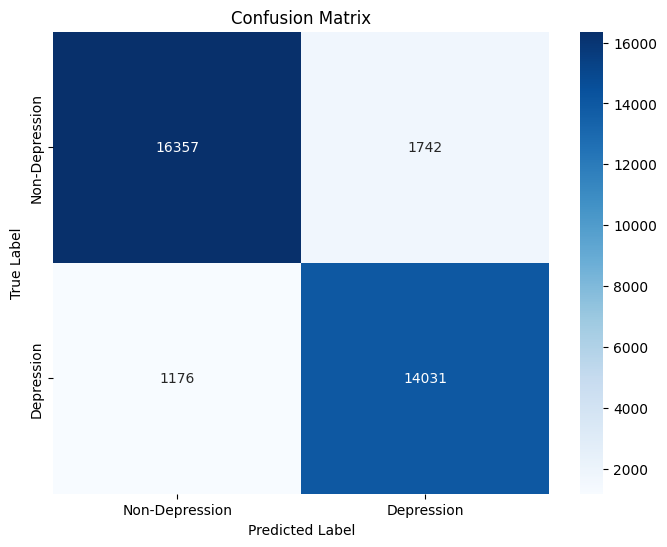

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_bilstm)

# Define class labels
class_labels = ['Non-Depression', 'Depression']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Calculate total number of samples
total_samples = cm.sum()

# Extract values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate percentages
tn_percentage = (tn / total_samples) * 100
fp_percentage = (fp / total_samples) * 100
fn_percentage = (fn / total_samples) * 100
tp_percentage = (tp / total_samples) * 100

# Print the confusion matrix with percentages
print("Confusion Matrix (Percentages):")
print(f"True Negative (Non-Depression correctly identified): {tn_percentage:.2f}%")
print(f"False Positive (Non-Depression misclassified as Depression): {fp_percentage:.2f}%")
print(f"False Negative (Depression misclassified as Non-Depression): {fn_percentage:.2f}%")
print(f"True Positive (Depression correctly identified): {tp_percentage:.2f}%")


Confusion Matrix (Percentages):
True Negative (Non-Depression correctly identified): 49.11%
False Positive (Non-Depression misclassified as Depression): 5.23%
False Negative (Depression misclassified as Non-Depression): 3.53%
True Positive (Depression correctly identified): 42.13%


In [ ]:
# Convert y_test and y_pred to NumPy arrays if they are not already
y_test = np.array(y_test)
y_pred = np.array(y_pred_bilstm).reshape(-1)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test, y_pred, df, and indices_test are already defined
true_negatives_indices = np.where((y_test == 0) & (y_pred == 0))[0]
true_positives_indices = np.where((y_test == 1) & (y_pred == 1))[0]
false_negatives_indices = np.where((y_test == 1) & (y_pred == 0))[0]
false_positives_indices = np.where((y_test == 0) & (y_pred == 1))[0]

In [ ]:
# Load the saved arrays
indices_test = np.load('/content/drive/MyDrive/pfa/depression_indices_test.npy')
df = pd.read_json('/content/drive/MyDrive/pfa/augmented_depression_data.json', orient='table')


In [ ]:
# Limit the number of samples to display to avoid overwhelming the session
num_samples_to_display = min(5, len(false_negatives_indices))  # Adjust the number as needed

# Assuming df is the original DataFrame containing 'text' and 'tokens' columns
for i in range(num_samples_to_display):
    test_index = false_negatives_indices[i]
    original_index = indices_test[test_index]  # Get the original index from the test set
    try:
        # Retrieve the text and tokens from the DataFrame
        text = df.loc[original_index, 'text']
        tokens = df.loc[original_index, 'tokens_back_to_text']
        print(f"Sample {i+1}:")
        print(f"Text: {text}")
        print(f"Tokens: {tokens}")
    except IndexError as e:
        print(f"IndexError for index {original_index}: {e}")

Sample 1:
Text: i falling apart right not way crying uncontrollably mental breakdown way slowly crumbling weight my familys schools expectations perfect little soldier need survive right grand scheme not matter my dad mom sister grandparents along cousins hate me think weird outright said it my face ones not hate me not heard me living hell it decided one day see anything turns better currently writing trying cry even my posts ability semi lost ago told men not cry yelled thing keeping me going little door hope things get better door seems closing wonder ill die come back conclusion my childhood room rope gun stool my plan jump stool gun hand shoot myself hanging it not instant not like pain want pain end seems quickest way daydream classes it even though still ok grades wise not ok mentally my mind fabric it crumbling break like going insane sometimes think feel already become physcopath waiting deaths cold comforting door choose believe no afterlife not want exist hope not sound like

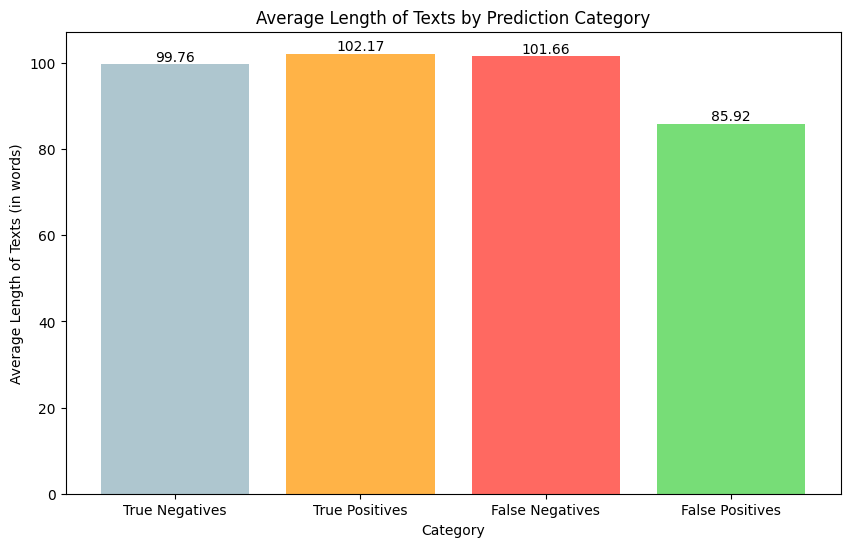

In [ ]:


def calculate_lengths(indices, df):
    lengths = []
    for idx in indices:
        original_index = indices_test[idx]
        try:
            text = df.loc[original_index, 'tokens_back_to_text']
            lengths.append(len(text.split()))  # Calculate length by number of words
        except IndexError as e:
            print(f"IndexError for index {original_index}: {e}")
    return lengths

true_negatives_lengths = calculate_lengths(true_negatives_indices, df)
true_positives_lengths = calculate_lengths(true_positives_indices, df)
false_negatives_lengths = calculate_lengths(false_negatives_indices, df)
false_positives_lengths = calculate_lengths(false_positives_indices, df)

avg_lengths = {
    'True Negatives': np.mean(true_negatives_lengths),
    'True Positives': np.mean(true_positives_lengths),
    'False Negatives': np.mean(false_negatives_lengths),
    'False Positives': np.mean(false_positives_lengths),
}

categories = list(avg_lengths.keys())
values = list(avg_lengths.values())

# Define pastel colors
colors = ['#AEC6CF', '#FFB347', '#FF6961', '#77DD77']

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=colors)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Average Length of Texts (in words)')
plt.title('Average Length of Texts by Prediction Category')
plt.show()


## BiLSTM-CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM

# Define the model
bilstm_cnn_model = Sequential()

# Add embedding layer
bilstm_cnn_model.add(Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=maxlen,
                                trainable=False))

# Add Convolutional layers
bilstm_cnn_model.add(Conv1D(128, 3, padding='same', activation='relu'))
bilstm_cnn_model.add(Conv1D(64, 3, padding='same', activation='relu'))
bilstm_cnn_model.add(MaxPooling1D())

# Add Bidirectional LSTM layers
bilstm_cnn_model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
bilstm_cnn_model.add(Bidirectional(LSTM(units=64)))

# Add Dense layer
bilstm_cnn_model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
bilstm_cnn_model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

# Print model summary
bilstm_cnn_model.summary()




Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 350, 300)          21780300  
                                                                 
 conv1d_6 (Conv1D)           (None, 350, 128)          115328    
                                                                 
 conv1d_7 (Conv1D)           (None, 350, 64)           24640     
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 175, 64)           0         
 g1D)                                                            
                                                                 
 bidirectional_4 (Bidirecti  (None, 175, 256)          197632    
 onal)                                                           
                                                                 
 bidirectional_5 (Bidirecti  (None, 128)              

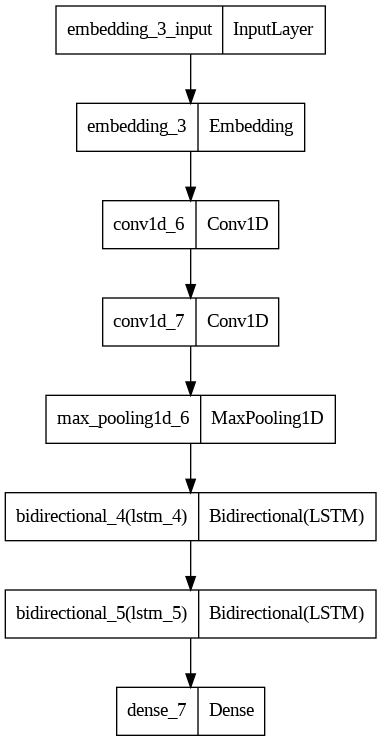

In [ ]:
plot_model(bilstm_cnn_model)

In [ ]:
# Fit the model
history = bilstm_cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
3331/3331 [==============================] - 118s 33ms/step - loss: 0.3337 - accuracy: 0.8504 - val_loss: 0.2223 - val_accuracy: 0.9055
Epoch 2/10
3331/3331 [==============================] - 110s 33ms/step - loss: 0.2102 - accuracy: 0.9114 - val_loss: 0.2009 - val_accuracy: 0.9170
Epoch 3/10
3331/3331 [==============================] - 125s 37ms/step - loss: 0.1900 - accuracy: 0.9195 - val_loss: 0.1934 - val_accuracy: 0.9196
Epoch 4/10
3331/3331 [==============================] - 109s 33ms/step - loss: 0.1733 - accuracy: 0.9282 - val_loss: 0.1917 - val_accuracy: 0.9214
Epoch 5/10
3331/3331 [==============================] - 109s 33ms/step - loss: 0.1579 - accuracy: 0.9351 - val_loss: 0.1932 - val_accuracy: 0.9185
Epoch 6/10
3331/3331 [==============================] - 120s 36ms/step - loss: 0.1460 - accuracy: 0.9409 - val_loss: 0.2046 - val_accuracy: 0.9183
Epoch 7/10
3331/3331 [==============================] - 108s 33ms/step - loss: 0.1330 - accuracy: 0.9470 - val_loss: 0

In [ ]:
# Save the model
bilstm_cnn_model.save('/content/drive/MyDrive/pfa/models/depression_bilstm_cnn_model_fasttext_350.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model
score = bilstm_cnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])


1041/1041 [==============================] - 14s 14ms/step - loss: 0.2881 - accuracy: 0.8997
Test Score: 0.28811201453208923
Test Accuracy: 0.8996877670288086


In [ ]:
# Make predictions
y_pred = bilstm_cnn_model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate Precision
precision = precision_score(y_test, y_pred_classes)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred_classes)
print("Recall:", recall)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_classes)
print("F1 Score:", f1)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)

1041/1041 [==============================] - 14s 12ms/step
Precision: 0.8500294985250737
Recall: 0.9474584073124219
F1 Score: 0.8961034922411917
ROC-AUC: 0.9693392518130184


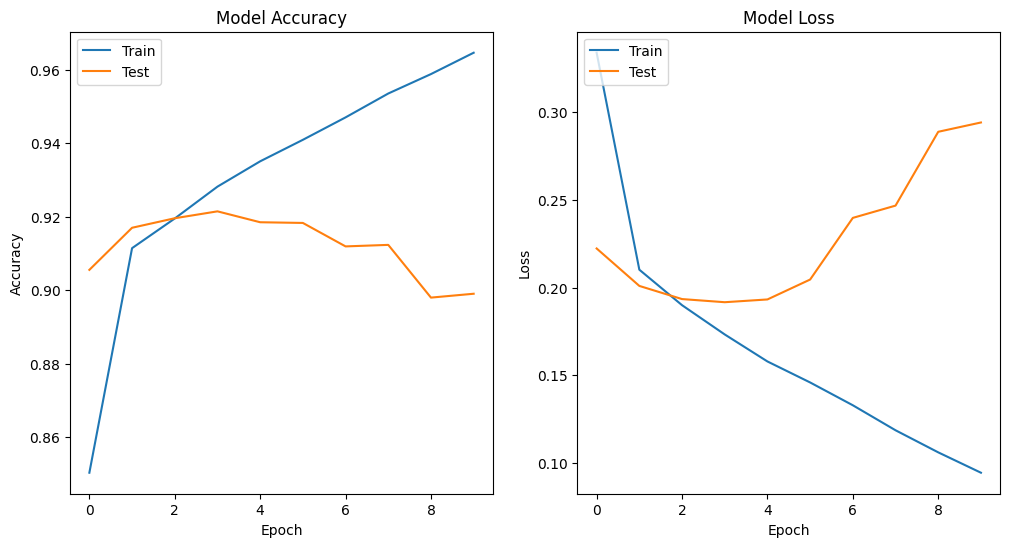

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()

### Confusion matrix

In [ ]:
from keras.models import load_model

# Load the model
bilstm_cnn_model = load_model("/content/drive/MyDrive/pfa/models/depression_bilstm_cnn_model_fasttext_350.h5")


In [ ]:
import numpy as np
import tensorflow as tf

# Load the test dataset
X_test = np.load('/content/drive/MyDrive/pfa/depression_X_test.npy')

In [ ]:
# Make predictions
y_pred_prob_bilstm_cnn = bilstm_cnn_model.predict(X_test)
# Convert probabilities to class labels
y_pred_bilstm_cnn = (y_pred_prob_bilstm_cnn > 0.5).astype(int)

1041/1041 [==============================] - 14s 12ms/step


In [ ]:
np.save('/content/drive/MyDrive/pfa/depression_y_pred_bilstm_cnn_fasttext.npy',y_pred_bilstm_cnn)

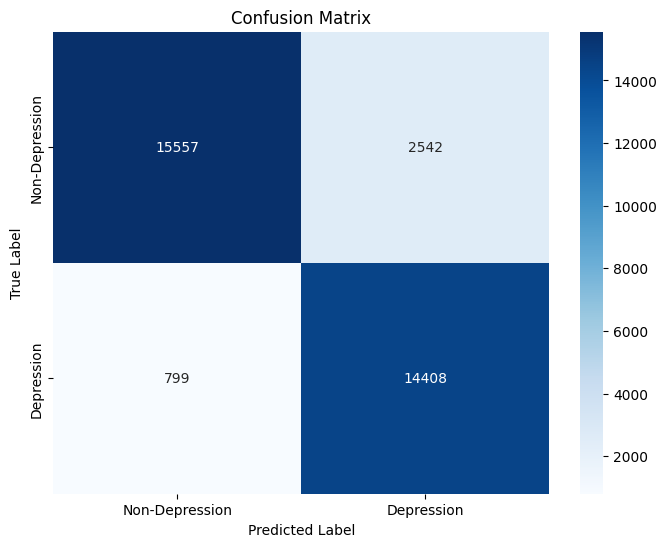

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_bilstm_cnn)

# Define class labels
class_labels = ['Non-Depression', 'Depression']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Calculate total number of samples
total_samples = cm.sum()

# Extract values from the confusion matrix
tn, fp, fn, tp = cm.ravel()

# Calculate percentages
tn_percentage = (tn / total_samples) * 100
fp_percentage = (fp / total_samples) * 100
fn_percentage = (fn / total_samples) * 100
tp_percentage = (tp / total_samples) * 100

# Print the confusion matrix with percentages
print("Confusion Matrix (Percentages):")
print(f"True Negative (Non-Depression correctly identified): {tn_percentage:.2f}%")
print(f"False Positive (Non-Depression misclassified as Depression): {fp_percentage:.2f}%")
print(f"False Negative (Depression misclassified as Non-Depression): {fn_percentage:.2f}%")
print(f"True Positive (Depression correctly identified): {tp_percentage:.2f}%")


Confusion Matrix (Percentages):
True Negative (Non-Depression correctly identified): 46.71%
False Positive (Non-Depression misclassified as Depression): 7.63%
False Negative (Depression misclassified as Non-Depression): 2.40%
True Positive (Depression correctly identified): 43.26%


In [ ]:
# Convert y_test and y_pred to NumPy arrays if they are not already
y_test = np.array(y_test)
y_pred = np.array(y_pred_bilstm_cnn).reshape(-1)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming y_test, y_pred, df, and indices_test are already defined
true_negatives_indices = np.where((y_test == 0) & (y_pred == 0))[0]
true_positives_indices = np.where((y_test == 1) & (y_pred == 1))[0]
false_negatives_indices = np.where((y_test == 1) & (y_pred == 0))[0]
false_positives_indices = np.where((y_test == 0) & (y_pred == 1))[0]


In [ ]:
# Limit the number of samples to display to avoid overwhelming the session
num_samples_to_display = min(5, len(false_negatives_indices))  # Adjust the number as needed

# Assuming df is the original DataFrame containing 'text' and 'tokens' columns
for i in range(num_samples_to_display):
    test_index = false_negatives_indices[i]
    original_index = indices_test.iloc[test_index]  # Get the original index from the test set
    try:
        # Retrieve the text and tokens from the DataFrame
        text = df.loc[original_index, 'text']
        tokens = df.loc[original_index, 'tokens_back_to_text']
        print(f"Sample {i+1}:")
        print(f"Text: {text}")
        print(f"Tokens: {tokens}")
    except IndexError as e:
        print(f"IndexError for index {original_index}: {e}")

In [ ]:

def calculate_lengths(indices, df):
    lengths = []
    for idx in indices:
        original_index = indices_test.iloc[idx]
        try:
            text = df.loc[original_index, 'tokens_back_to_text']
            lengths.append(len(text.split()))  # Calculate length by number of words
        except IndexError as e:
            print(f"IndexError for index {original_index}: {e}")
    return lengths

true_negatives_lengths = calculate_lengths(true_negatives_indices, df)
true_positives_lengths = calculate_lengths(true_positives_indices, df)
false_negatives_lengths = calculate_lengths(false_negatives_indices, df)
false_positives_lengths = calculate_lengths(false_positives_indices, df)

avg_lengths = {
    'True Negatives': np.mean(true_negatives_lengths),
    'True Positives': np.mean(true_positives_lengths),
    'False Negatives': np.mean(false_negatives_lengths),
    'False Positives': np.mean(false_positives_lengths),
}

categories = list(avg_lengths.keys())
values = list(avg_lengths.values())

# Define pastel colors
colors = ['#AEC6CF', '#FFB347', '#FF6961', '#77DD77']

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=colors)

# Add numbers on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

plt.xlabel('Category')
plt.ylabel('Average Length of Texts (in words)')
plt.title('Average Length of Texts by Prediction Category')
plt.show()

## Find Common False Negatives

In [ ]:
# Load the saved arrays
y_test = np.load('/content/drive/MyDrive/pfa/depression_y_test.npy')
indices_test = np.load('/content/drive/MyDrive/pfa/depression_indices_test.npy')
y_pred_cnn = np.load('/content/drive/MyDrive/pfa/depression_y_pred_cnn_fasttext.npy')
y_pred_bilstm = np.load('/content/drive/MyDrive/pfa/depression_y_pred_Bilstm_fasttext.npy')
y_pred_bilstm_cnn = np.load('/content/drive/MyDrive/pfa/depression_y_pred_bilstm_cnn_fasttext.npy')

In [ ]:
indices_test = np.array(indices_test)
y_test = np.array(y_test)
y_pred_cnn = np.array(y_pred_cnn).reshape(-1)
y_pred_bilstm = np.array(y_pred_bilstm).reshape(-1)
y_pred_bilstm_cnn = np.array(y_pred_bilstm_cnn).reshape(-1)

In [ ]:
import numpy as np

false_negatives_bilstm = np.where((y_test == 1) & (y_pred_bilstm == 0))[0]
false_negatives_cnn = np.where((y_test == 1) & (y_pred_cnn == 0))[0]
false_negatives_bilstm_cnn = np.where((y_test == 1) & (y_pred_bilstm_cnn == 0))[0]


In [ ]:
# Find the intersection of false negatives
common_false_negatives = np.intersect1d(false_negatives_bilstm, false_negatives_cnn)
common_false_negatives = np.intersect1d(common_false_negatives, false_negatives_bilstm_cnn)


In [ ]:
common_false_negatives_count = len(common_false_negatives)
print(f"Count of common false negatives: {common_false_negatives_count}")

Count of common false negatives: 5299


In [ ]:
# Limit the number of samples to display to avoid overwhelming the session
num_samples_to_display = min(10, len(common_false_negatives))

# Assuming df is the original DataFrame containing 'text' and 'tokens_back_to_text' columns
for i in range(num_samples_to_display):
    test_index = common_false_negatives[i]
    original_index = indices_test[test_index]  # Access directly from the numpy array
    try:
        # Retrieve the text and tokens from the DataFrame
        text = df.loc[original_index, 'text']
        tokens = df.loc[original_index, 'tokens_back_to_text']
        print(f"Sample {i+1}:")
        print(f"Text: {text}")
        print(f"Tokens: {tokens}")
    except IndexError as e:
        print(f"IndexError for index {original_index}: {e}")

Sample 1:
Text: falling apart right way crying uncontrollably mental breakdown way slowly crumbling weight familys schools expectations perfect little soldier need survive right grand scheme matter dad mom sister grandparents along cousins hate think weird outright said face ones hate heard living hell decided one day see anything turns better currently writing trying cry even posts ability semi lost ago told men cry yelled thing keeping going little door hope things get better door seems closing wonder ill die come back conclusion childhood room rope gun stool plan jump stool gun hand shoot hanging instant like pain want pain end seems quickest way daydream classes even though still ok grades wise ok mentally mind fabric crumbling break like going insane sometimes think feel already become physcopath waiting deaths cold comforting door choose believe afterlife want exist hope sound like im andthisisdeep type person care anymore
Tokens: fall apart right way cry uncontrollably mental br



## CBA


In [ ]:
embedding_path='/content/drive/MyDrive/pfa/embedding_matrix/depression_fasttext_embedding_matrix.npy'
embedding_matrix=np.load(embedding_path)
embedding_dim = embedding_matrix.shape[1]
vocab_size = embedding_matrix.shape[0]
print(embedding_dim)

300


In [ ]:
X_train = np.load('/content/drive/MyDrive/pfa/depression_X_train.npy')
y_train = np.load('/content/drive/MyDrive/pfa/depression_y_train.npy')
X_test = np.load('/content/drive/MyDrive/pfa/depression_X_test.npy')
y_test = np.load('/content/drive/MyDrive/pfa/depression_y_test.npy')

In [ ]:
X_train.shape

(133220, 350)

In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, Layer, SpatialDropout1D
from keras.layers import LayerNormalization
from keras.optimizers import Adam

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='att_u', shape=(input_shape[-1],), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        ait = tf.nn.softmax(ait)
        ait = tf.expand_dims(ait, axis=-1)
        output = x * ait
        return tf.reduce_sum(output, axis=1)

def create_cba_model(vocab_size, embedding_dim, embedding_matrix, maxlen):
    inputs = Input(shape=(maxlen,))

    # Embedding layer
    embedding = Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          weights=[embedding_matrix],
                          input_length=maxlen,
                          trainable=False)(inputs)

    # Spatial Dropout
    x = SpatialDropout1D(0.2)(embedding)

    # Convolutional layers with max pooling
    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)
    x = Conv1D(128, 5, activation='relu', padding='same')(x)
    x = MaxPooling1D(pool_size=3)(x)

    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)

    # Attention mechanism
    x = AttentionLayer()(x)

    # Dense layers with Dropout and Layer Normalization
    x = LayerNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

# Load embedding matrix
embedding_path = '/content/drive/MyDrive/pfa/embedding_matrix/depression_fasttext_embedding_matrix.npy'
embedding_matrix = np.load(embedding_path)
embedding_dim = embedding_matrix.shape[1]
vocab_size = embedding_matrix.shape[0]

maxlen = 350  # sequence length as mentioned in the description

# Create the model
cba_model = create_cba_model(vocab_size=vocab_size,
                             embedding_dim=embedding_dim,
                             embedding_matrix=embedding_matrix,
                             maxlen=maxlen)

# Print model summary
cba_model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 350)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 350, 300)          21771000  
                                                                 
 spatial_dropout1d_2 (Spati  (None, 350, 300)          0         
 alDropout1D)                                                    
                                                                 
 conv1d_6 (Conv1D)           (None, 350, 128)          192128    
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 116, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_7 (Conv1D)           (None, 116, 128)          8204

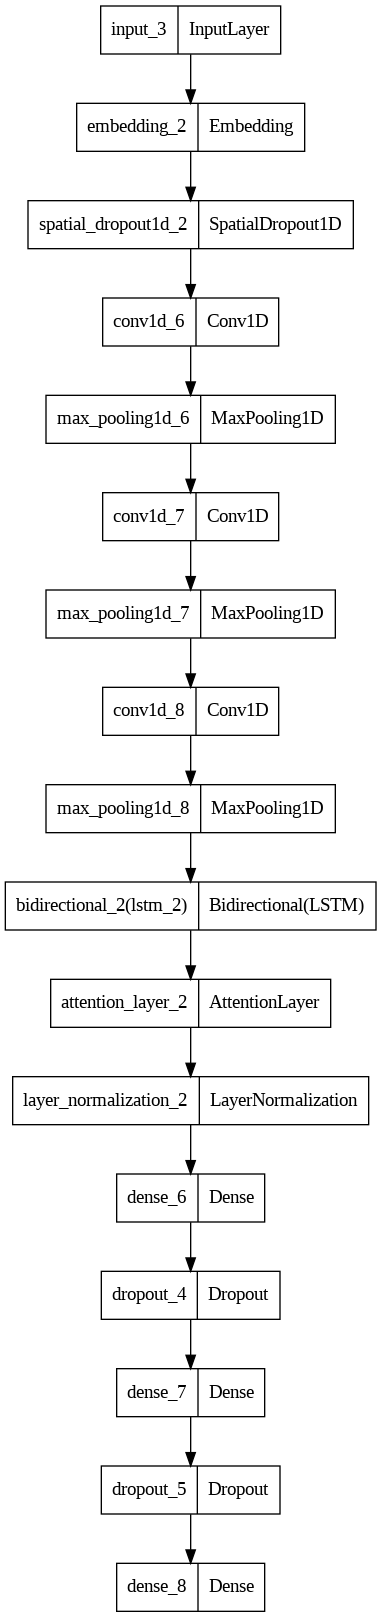

In [ ]:
plot_model(cba_model)

In [ ]:
history = cba_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
3331/3331 [==============================] - 361s 104ms/step - loss: 0.6508 - accuracy: 0.6029 - val_loss: 0.5586 - val_accuracy: 0.7236
Epoch 2/10
3331/3331 [==============================] - 338s 101ms/step - loss: 0.3931 - accuracy: 0.8122 - val_loss: 0.3028 - val_accuracy: 0.8636
Epoch 3/10
3331/3331 [==============================] - 348s 105ms/step - loss: 0.2940 - accuracy: 0.8655 - val_loss: 0.2848 - val_accuracy: 0.8725
Epoch 4/10
3331/3331 [==============================] - 348s 104ms/step - loss: 0.2683 - accuracy: 0.8801 - val_loss: 0.2644 - val_accuracy: 0.8801
Epoch 5/10
3331/3331 [==============================] - 342s 103ms/step - loss: 0.2531 - accuracy: 0.8895 - val_loss: 0.2534 - val_accuracy: 0.8877
Epoch 6/10
3331/3331 [==============================] - 338s 102ms/step - loss: 0.2381 - accuracy: 0.8959 - val_loss: 0.2777 - val_accuracy: 0.8680
Epoch 7/10
3331/3331 [==============================] - 342s 103ms/step - loss: 0.2275 - accuracy: 0.9024 - val_

In [ ]:
# Save the model
cba_model.save('/content/drive/MyDrive/pfa/models/depression_cba_model_fasttext.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate the model
score = cba_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

1041/1041 [==============================] - 15s 15ms/step - loss: 0.2608 - accuracy: 0.8878
Test Score: 0.26078295707702637
Test Accuracy: 0.8877679705619812


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


# Make predictions
y_pred = cba_model.predict(X_test)
y_pred_classes = np.round(y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate Precision
precision = precision_score(y_test, y_pred_classes)
print("Precision:", precision)

# Calculate Recall
recall = recall_score(y_test, y_pred_classes)
print("Recall:", recall)

# Calculate F1 Score
f1 = f1_score(y_test, y_pred_classes)
print("F1 Score:", f1)

# Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC:", roc_auc)

1041/1041 [==============================] - 13s 12ms/step
Precision: 0.8458893781289584
Recall: 0.9222068784112579
F1 Score: 0.88240105706915
ROC-AUC: 0.9631091780619743


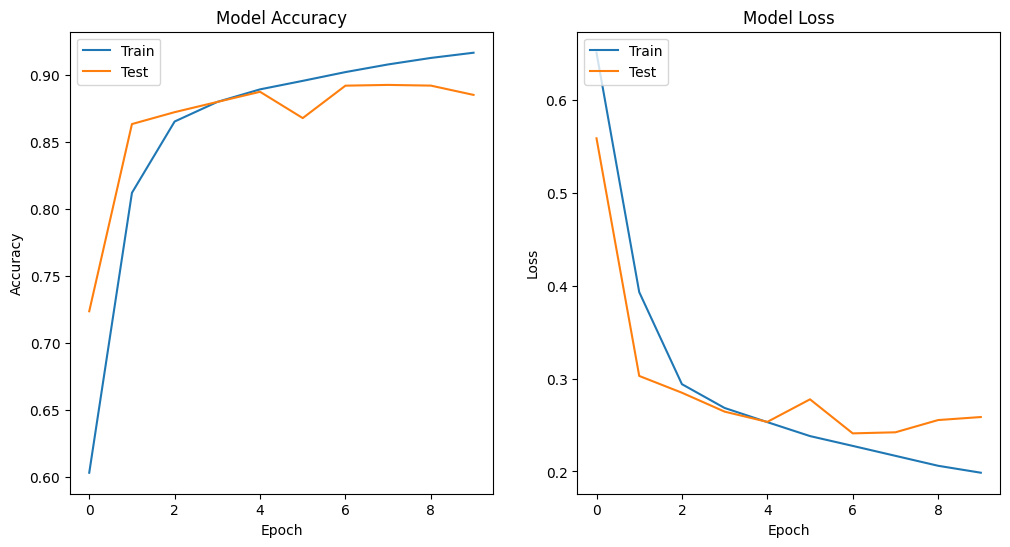

In [ ]:
# Plotting accuracy and loss
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Show plots
plt.show()

### Confusion Matrix

In [ ]:
from keras.models import load_model

# Load the model
cba_model = load_model("/content/drive/MyDrive/pfa/models/depression_cba_model_fasttext.h5")

ValueError: Unknown layer: 'AttentionLayer'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
import numpy as np
import tensorflow as tf

# Load the test dataset
X_test = np.load('/content/drive/MyDrive/pfa/depression_X_test.npy')

In [ ]:
# Make predictions
y_pred_prob_cba = cba_model.predict(X_test)
# Convert probabilities to class labels
y_pred_cba = (y_pred_prob_cba > 0.5).astype(int)

1041/1041 [==============================] - 12s 12ms/step


In [ ]:
np.save('/content/drive/MyDrive/pfa/depression_y_pred_cba_fasttext.npy',y_pred_cba)

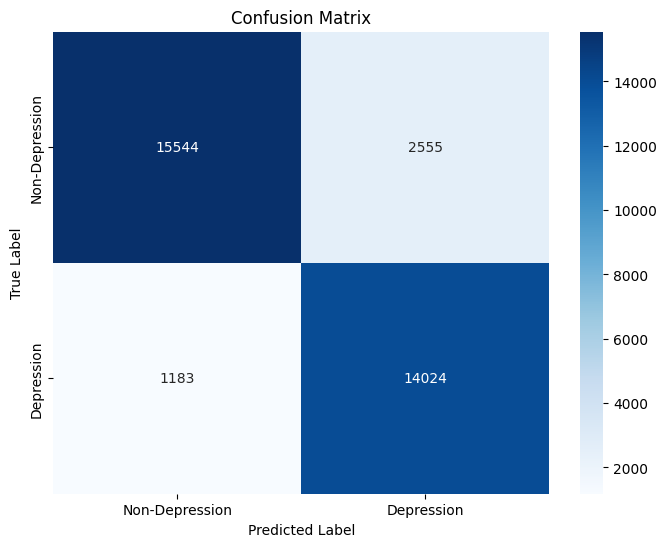

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_cba)

# Define class labels
class_labels = ['Non-Depression', 'Depression']

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# transformer-based language models.

## Fine Tune Bert

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer

In [ ]:
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [ ]:
model = TFAutoModel.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/pfa/augmented_data.csv')


In [ ]:
#reddits

In [ ]:
max_length = 128

# Tokenize function
def tokenize(texts):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")

In [ ]:
# Assuming your labels are in a column named 'labels'
texts = df['tokens_back_to_text'].values
labels = df['depression'].values

In [ ]:
# Split the dataset into training and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [ ]:
# Tokenize the texts
train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)

In [ ]:
# Create TensorFlow datasets from the generator
batch_size = 32
train_steps_per_epoch = len(train_texts) // batch_size
test_steps = len(test_texts) // batch_size

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask'],
        'token_type_ids': train_encodings['token_type_ids']
    },
    train_labels
)).batch(batch_size)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask'],
        'token_type_ids': test_encodings['token_type_ids']
    },
    test_labels
)).batch(batch_size)

In [ ]:
# Manually iterate over the training dataset to check the output
for data in train_dataset.take(1):
    print(data)

({'input_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[  101,  4299,  2514, ...,     0,     0,     0],
       [  101,  2342, 21358, ...,     0,     0,     0],
       [  101,  3066,  2659, ...,     0,     0,     0],
       ...,
       [  101,  3087,  2842, ...,     0,     0,     0],
       [  101,  3246,  2801, ...,     0,     0,     0],
       [  101,  2460,  2743, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(16, 128), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>

In [ ]:
# Define BERT classification model
class BERTForClassification(tf.keras.Model):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')  # Binary classification

    def call(self, inputs):
        bert_output = self.bert(input_ids=inputs['input_ids'],
                                attention_mask=inputs['attention_mask'],
                                token_type_ids=inputs['token_type_ids'])
        pooled_output = bert_output[1]  # Use the pooled output for classification
        return self.fc(pooled_output)

In [ ]:
# Create an instance of the model
classifier = BERTForClassification(model)

In [ ]:
# Compile the model
classifier.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = classifier.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset
)

Epoch 1/3
8317/8317 [==============================] - 3873s 458ms/step - loss: 0.1930 - accuracy: 0.9172 - val_loss: 0.1888 - val_accuracy: 0.9181
Epoch 2/3
1195/8317 [===>..........................] - ETA: 49:24 - loss: 0.1515 - accuracy: 0.9390

In [ ]:
# Save the model
classifier.save('/content/drive/MyDrive/pfa/models/depression_bert_fine_tuned.h5')

In [ ]:
# Evaluate the model on the test dataset
evaluation = classifier.evaluate(test_dataset, steps=test_steps)

# Print the output
print(f"Loss: {evaluation[0]:.4f}")
print(f"Accuracy: {evaluation[1]:.4f}")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Evaluate the model
y_true = []
y_pred = []

for batch in test_dataset:
    X, y = batch
    preds = classifier.predict(X)
    y_true.extend(y.numpy())
    y_pred.extend(preds.flatten())

# Convert predictions to binary labels
y_pred_bin = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Calculate precision, recall, F1 score, and ROC AUC
precision = precision_score(y_true, y_pred_bin)
recall = recall_score(y_true, y_pred_bin)
f1 = f1_score(y_true, y_pred_bin)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

In [ ]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_path = '/content/drive/MyDrive/pfa/models/bert_classifier.zip'
extracted_dir_path = '/content/bert_classifier'

# Create a directory to extract the zip file
os.makedirs(extracted_dir_path, exist_ok=True)

# Unzip the model file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print("Model extracted successfully.")


Model extracted successfully.


## Distilbert

In [ ]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
# Enable mixed precision training
from keras.mixed_precision import set_global_policy, Policy
set_global_policy('mixed_float16')


In [ ]:
# Load smaller BERT model and tokenizer
model = TFAutoModel.from_pretrained("distilbert-base-uncased")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/pfa/augmented_data.csv')
max_length = 128

In [ ]:
# Tokenize function
def tokenize(texts):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")


In [ ]:
# Extract texts and labels
texts = df['tokens_back_to_text'].values
labels = df['depression'].values


In [ ]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:
# Tokenize the texts
train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)


In [ ]:
# Create TensorFlow datasets
batch_size = 16

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).batch(batch_size)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    test_labels
)).batch(batch_size)


In [ ]:
# Define BERT classification model
class BERTForClassification(tf.keras.Model):
    def __init__(self, bert_model):
        super().__init__()
        self.bert = bert_model
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')  # Binary classification

    def call(self, inputs):
        bert_output = self.bert(input_ids=inputs['input_ids'],
                                attention_mask=inputs['attention_mask'])
        pooled_output = bert_output[0][:, 0]  # Use the first token (CLS) for classification
        return self.fc(pooled_output)


In [ ]:

# Create an instance of the model
classifier = BERTForClassification(model)


### training

In [ ]:
# Define optimizer with mixed precision
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

In [ ]:
# Compile the model
classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model
history = classifier.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset
)


Epoch 1/3
8317/8317 [==============================] - 1974s 231ms/step - loss: 0.2002 - accuracy: 0.9137 - val_loss: 0.1935 - val_accuracy: 0.9165
Epoch 2/3
8317/8317 [==============================] - 1937s 233ms/step - loss: 0.1554 - accuracy: 0.9352 - val_loss: 0.1827 - val_accuracy: 0.9237
Epoch 3/3
5124/8317 [=================>............] - ETA: 11:08 - loss: 0.1223 - accuracy: 0.9507

### evaluation

In [ ]:
# Evaluate the model on the test dataset
evaluation = classifier.evaluate(test_dataset)

# Print loss and accuracy
print(f"Loss: {evaluation[0]:.4f}")
print(f"Accuracy: {evaluation[1]:.4f}")


In [ ]:

# Get predictions
y_true = []
y_pred = []

for batch in test_dataset:
    X, y = batch
    preds = classifier.predict(X)
    y_true.extend(y.numpy())
    y_pred.extend(preds.flatten())

# Convert predictions to binary labels
y_pred_bin = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Calculate precision, recall, F1 score, and ROC AUC
precision = precision_score(y_true, y_pred_bin)
recall = recall_score(y_true, y_pred_bin)
f1 = f1_score(y_true, y_pred_bin)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

In [ ]:
# Save the model
classifier.save('/content/drive/MyDrive/pfa/models/depression_distilbert_fine_tuned.h5')

## Roberta

In [ ]:
# Enable mixed precision training
from keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')


In [ ]:
# Load RoBERTa model and tokenizer
model = TFAutoModel.from_pretrained("roberta-base")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")


In [ ]:
# Load dataset
df = pd.read_csv('/content/drive/MyDrive/pfa/augmented_data.csv')
max_length = 250


In [ ]:
# Tokenize function
def tokenize(texts):
    return tokenizer(texts.tolist(), padding='max_length', truncation=True, max_length=max_length, return_tensors="tf")


In [ ]:
# Extract texts and labels
texts = df['tokens_back_to_text'].values
labels = df['depression'].values


In [ ]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [ ]:
# Tokenize the texts
train_encodings = tokenize(train_texts)
test_encodings = tokenize(test_texts)


In [ ]:
# Create TensorFlow datasets
batch_size = 32


In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': train_encodings['input_ids'],
        'attention_mask': train_encodings['attention_mask']
    },
    train_labels
)).batch(batch_size)


In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'input_ids': test_encodings['input_ids'],
        'attention_mask': test_encodings['attention_mask']
    },
    test_labels
)).batch(batch_size)


In [ ]:
# Define RoBERTa classification model
class RoBERTaForClassification(tf.keras.Model):
    def __init__(self, roberta_model):
        super().__init__()
        self.roberta = roberta_model
        self.fc = tf.keras.layers.Dense(1, activation='sigmoid', dtype='float32')  # Binary classification

    def call(self, inputs):
        roberta_output = self.roberta(input_ids=inputs['input_ids'],
                                      attention_mask=inputs['attention_mask'])
        pooled_output = roberta_output[0][:, 0]  # Use the first token (CLS) for classification
        return self.fc(pooled_output)


In [ ]:
# Create an instance of the model
classifier = RoBERTaForClassification(model)


In [ ]:
# Define optimizer with mixed precision
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)


In [ ]:
# Compile the model
classifier.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
# Train the model
history = classifier.fit(
    train_dataset,
    epochs=3,
    validation_data=test_dataset
)


In [ ]:
# Evaluate the model on the test dataset
evaluation = classifier.evaluate(test_dataset)

# Print loss and accuracy
print(f"Loss: {evaluation[0]:.4f}")
print(f"Accuracy: {evaluation[1]:.4f}")



In [ ]:
# Get predictions
y_true = []
y_pred = []

for batch in test_dataset:
    X, y = batch
    preds = classifier.predict(X)
    y_true.extend(y.numpy())
    y_pred.extend(preds.flatten())

# Convert predictions to binary labels
y_pred_bin = [1 if pred >= 0.5 else 0 for pred in y_pred]

# Calculate precision, recall, F1 score, and ROC AUC
precision = precision_score(y_true, y_pred_bin)
recall = recall_score(y_true, y_pred_bin)
f1 = f1_score(y_true, y_pred_bin)
roc_auc = roc_auc_score(y_true, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")